# DMD Analysis on Cylinder Flow Dataset

## Overview
1. **Single Sample Analysis**: Fit DMD on individual samples and perform autoregressive prediction
2. **Large Sample Analysis**: Load pre-trained DMD model and analyze validation set predictions
3. **Multi-Channel Analysis**: Detailed investigation of u and v velocity components
4. **Mode Analysis**: Visualization and interpretation of DMD modes
5. **Flow Field Visualization**: Streamlines, vorticity, and velocity magnitude analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our DMD classes and utilities
import sys
sys.path.append('../../')

# Import our DMD classes and utilities
from src.models.DMD.dmd import DMD, StreamingDMD
from src.models.DMD.utils import DMDDataLoader

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Configuration
DATA_PATH = "../../data"
MODEL_PATH = "../../results/checkpoints/DMD"
SAMPLE_IDX = 3  # Which sample to analyze for single sample analysis
PREDICTION_STEPS = 1000  # Number of steps to predict
RANDOM_SEED = 42
TARGET_RESOLUTION = (64, 64)  # Resize resolution for analysis

np.random.seed(RANDOM_SEED)

print("="*60)
print("DMD Analysis Configuration for Cylinder Flow")
print("="*60)
print(f"Data path: {DATA_PATH}")
print(f"Model path: {MODEL_PATH}")
print(f"Sample index for analysis: {SAMPLE_IDX}")
print(f"Prediction steps: {PREDICTION_STEPS}")
print(f"Target resolution: {TARGET_RESOLUTION}")
print("="*60)

DMD Analysis Configuration for Cylinder Flow
Data path: ../../data
Model path: ../../results/checkpoints/DMD
Sample index for analysis: 3
Prediction steps: 1000
Target resolution: (64, 64)


## 1. Data Loading and Preprocessing

In [4]:
# Load Cylinder dataset
print("Loading Cylinder dataset...")
data_loader = DMDDataLoader(
    dataset_name="cylinder",
    data_path=DATA_PATH,
    normalize=True,
    train_ratio=0.8,
    random_seed=RANDOM_SEED,
    target_resolution=TARGET_RESOLUTION,
    interpolation_mode='bilinear'
)

# Get dataset statistics
stats = data_loader.get_data_stats()
print("\nDataset Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")

# Get train and validation datasets
train_dataset = data_loader.train_dataset
val_dataset = data_loader.val_dataset

print(f"\nData shapes:")
print(f"  Train data: {train_dataset.data.shape}")  # [samples, time, channels, spatial_features]
print(f"  Val data: {val_dataset.data.shape}")

print(f"\nNormalization parameters:")
print(f"  Mean shape: {train_dataset.mean.shape}")
print(f"  Std shape: {train_dataset.std.shape}")
print(f"  Mean range: [{train_dataset.mean.min():.6f}, {train_dataset.mean.max():.6f}]")
print(f"  Std range: [{train_dataset.std.min():.6f}, {train_dataset.std.max():.6f}]")

Loading Cylinder dataset...
Case case0001: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0002: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0003: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0004: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0005: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0006: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0007: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0008: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0009: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0010: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0011: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0012: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0013: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0014: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0015: u shape = (1000, 64, 64), v shape

In [5]:
def denormalize_cylinder_data(data, mean, std):
    """
    Denormalize cylinder data
    
    Args:
        data: Normalized data [features, time] or [time, features] or [time, channels, spatial]
        mean: Mean values used for normalization
        std: Std values used for normalization
    
    Returns:
        Denormalized data
    """
    if data.ndim == 3:  # [time, channels, spatial]
        return data * std + mean
    elif data.ndim == 2:
        if data.shape[0] == mean.shape[2]:  # [features, time]
            # Reshape mean and std for broadcasting
            mean_reshaped = mean.reshape(-1, 1)  # [features, 1]
            std_reshaped = std.reshape(-1, 1)   # [features, 1]
            return data * std_reshaped + mean_reshaped
        else:  # [time, features]
            mean_flat = mean.flatten()
            std_flat = std.flatten()
            return data * std_flat + mean_flat
    elif data.ndim == 1:  # 1D array
        mean_flat = mean.flatten()
        std_flat = std.flatten()
        return data * std_flat + mean_flat
    else:
        raise ValueError(f"Unsupported data dimension: {data.ndim}")

def reshape_cylinder_data(data, height, width, channels=2):
    """
    Reshape cylinder data from flattened to spatial format
    
    Args:
        data: Flattened data [..., channels * height * width]
        height, width: Spatial dimensions
        channels: Number of channels (u, v components)
    
    Returns:
        Reshaped data [..., channels, height, width]
    """
    if data.ndim == 1:  # [features]
        return data.reshape(channels, height, width)
    elif data.ndim == 2:  # [time, features] or [features, time]
        if data.shape[-1] == channels * height * width:
            return data.reshape(*data.shape[:-1], channels, height, width)
        else:
            return data.T.reshape(data.shape[1], channels, height, width)
    else:
        return data.reshape(*data.shape[:-1], channels, height, width)

def visualize_cylinder_flow(u_field, v_field, title="Cylinder Flow", figsize=(15, 5), 
                           show_streamlines=True, show_cylinder=True):
    """
    Visualize cylinder flow field with u, v components and streamlines
    
    Args:
        u_field: U velocity component [height, width]
        v_field: V velocity component [height, width]
        title: Plot title
        figsize: Figure size
        show_streamlines: Whether to show streamlines
        show_cylinder: Whether to show cylinder outline
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Create coordinate grids
    height, width = u_field.shape
    Y, X = np.mgrid[0:height, 0:width]
    
    # Velocity magnitude
    velocity_mag = np.sqrt(u_field**2 + v_field**2)
    
    # U component
    im1 = axes[0].imshow(u_field, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[0].set_title('U Velocity')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    plt.colorbar(im1, ax=axes[0])
    
    # V component
    im2 = axes[1].imshow(v_field, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[1].set_title('V Velocity')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    plt.colorbar(im2, ax=axes[1])
    
    # Velocity magnitude with streamlines
    im3 = axes[2].imshow(velocity_mag, cmap='viridis', aspect='equal', origin='lower')
    axes[2].set_title('Velocity Magnitude')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    plt.colorbar(im3, ax=axes[2])
    
    # Add streamlines
    if show_streamlines:
        # Subsample for cleaner streamlines
        step = max(1, min(height, width) // 20)
        axes[2].streamplot(X[::step, ::step], Y[::step, ::step], 
                          u_field[::step, ::step], v_field[::step, ::step], 
                          color='white', density=0.8, linewidth=0.8)
    
    # Add cylinder outline (approximate)
    if show_cylinder:
        cylinder_center = (width * 0.2, height * 0.5)  # Approximate cylinder position
        cylinder_radius = min(height, width) * 0.05   # Approximate cylinder size
        
        for ax in axes:
            circle = plt.Circle(cylinder_center, cylinder_radius, 
                              fill=False, color='red', linewidth=2, linestyle='--')
            ax.add_patch(circle)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig, axes

def compute_vorticity(u_field, v_field):
    """
    Compute vorticity from velocity components
    
    Args:
        u_field: U velocity component [height, width]
        v_field: V velocity component [height, width]
    
    Returns:
        Vorticity field [height, width]
    """
    # Compute gradients
    du_dy, du_dx = np.gradient(u_field)
    dv_dy, dv_dx = np.gradient(v_field)
    
    # Vorticity = ∂v/∂x - ∂u/∂y
    vorticity = dv_dx - du_dy
    
    return vorticity


## 2. Single Sample DMD Analysis

In [6]:
print("="*60)
print("PART 1: SINGLE SAMPLE DMD ANALYSIS")
print("="*60)

# Get a single sample from training set
sample_data = train_dataset.data[SAMPLE_IDX]  # [time_steps, channels, spatial_features]
print(f"Selected sample shape: {sample_data.shape}")
print(f"Sample index: {SAMPLE_IDX}")

# Reshape for DMD: flatten channels and spatial dimensions
time_steps, channels, spatial_features = sample_data.shape
sample_flattened = sample_data.reshape(time_steps, channels * spatial_features)

# Transpose to DMD format: [features, time_steps]
sample_dmd_format = sample_flattened.T
print(f"DMD format shape: {sample_dmd_format.shape}")

# Calculate spatial dimensions
total_features = channels * spatial_features
height, width = TARGET_RESOLUTION
print(f"Spatial resolution: {height} x {width}")
print(f"Channels: {channels} (u, v components)")


PART 1: SINGLE SAMPLE DMD ANALYSIS
Selected sample shape: (1000, 2, 4096)
Sample index: 3
DMD format shape: (8192, 1000)
Spatial resolution: 64 x 64
Channels: 2 (u, v components)


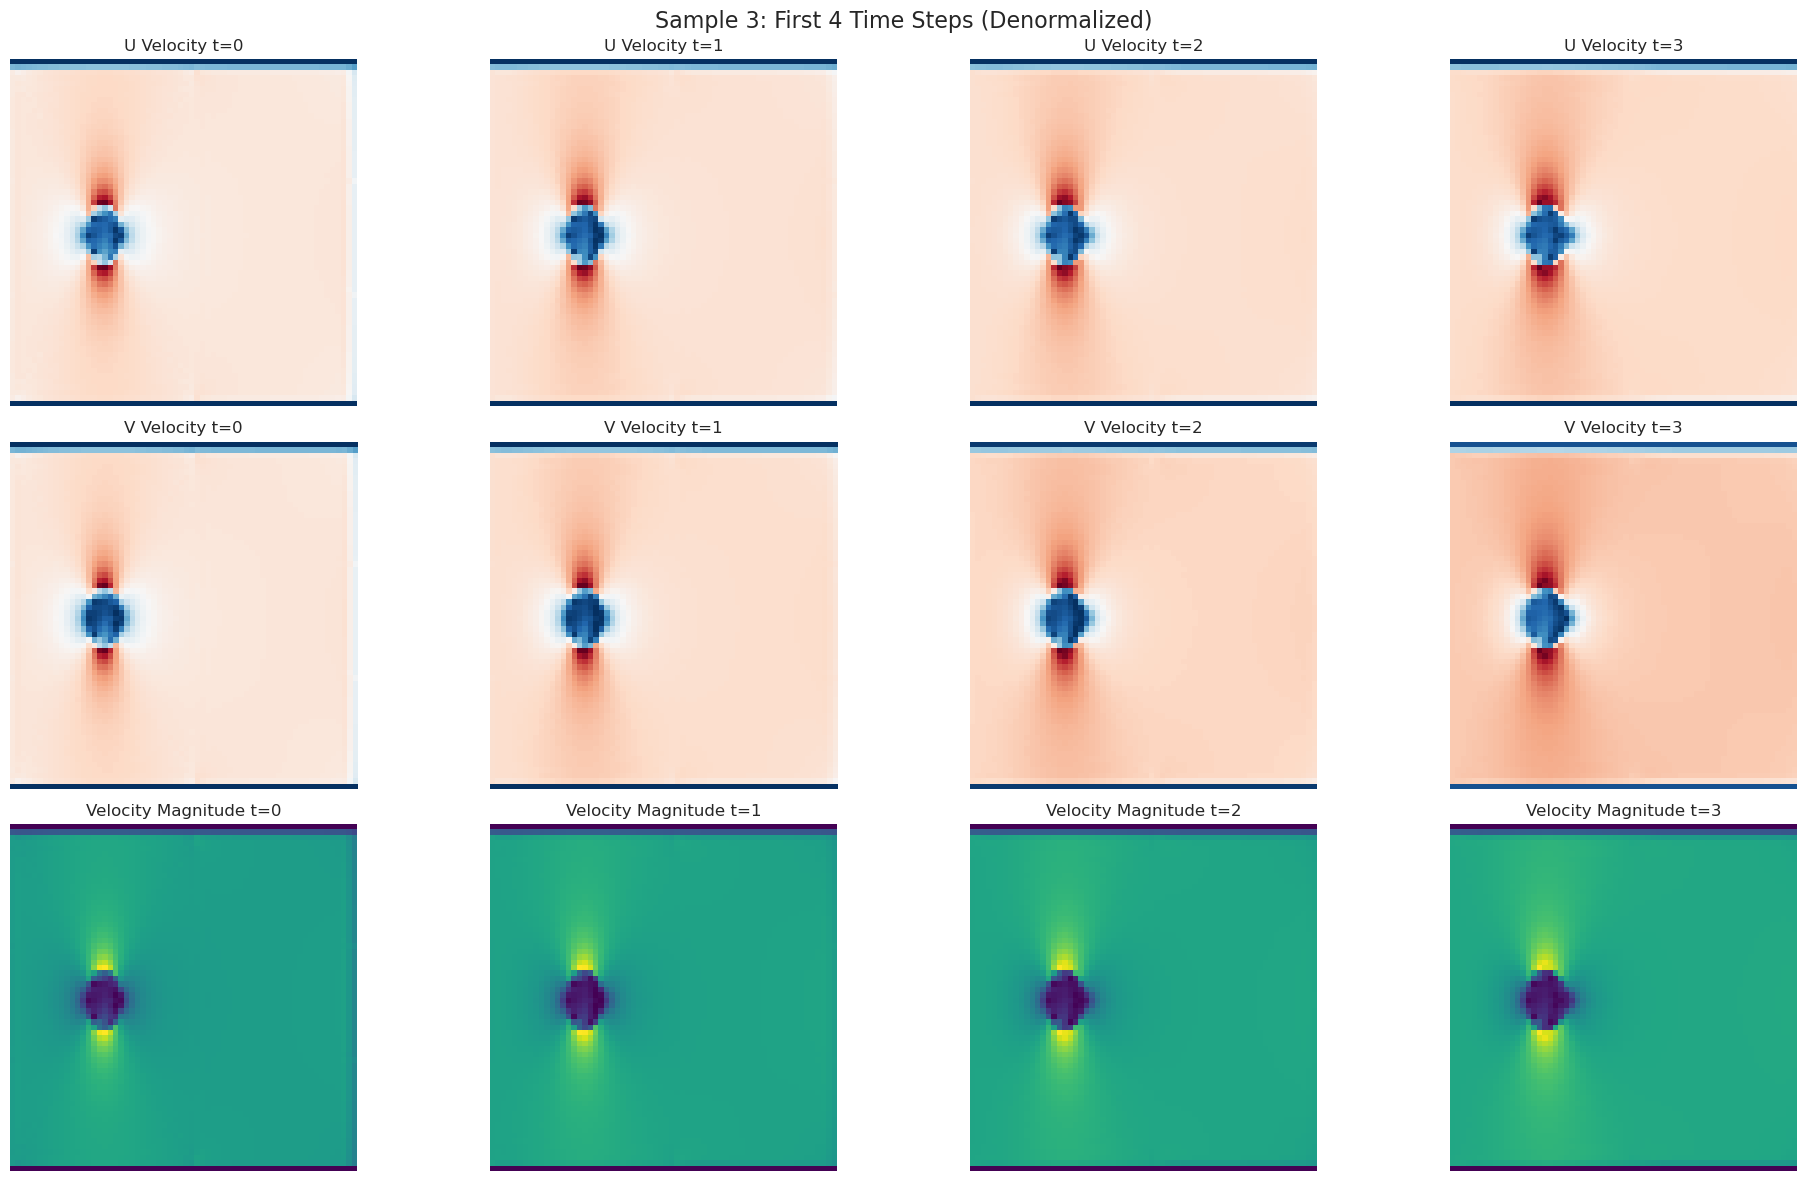

In [7]:
# Visualize the first few time steps of the sample
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

for i in range(4):
    if i < sample_data.shape[0]:
        # Get data for this time step
        time_data = sample_data[i]  # [channels, spatial_features]
        
        # Denormalize
        denorm_data = denormalize_cylinder_data(time_data, train_dataset.mean, train_dataset.std)
        
        # Reshape to spatial format
        u_field = denorm_data[0].reshape(height, width)
        v_field = denorm_data[1].reshape(height, width)
        velocity_mag = np.sqrt(u_field**2 + v_field**2)
        
        # Plot u component
        im1 = axes[0, i].imshow(u_field, cmap='RdBu_r', aspect='equal', origin='lower')
        axes[0, i].set_title(f'U Velocity t={i}')
        axes[0, i].axis('off')
        
        # Plot v component
        im2 = axes[1, i].imshow(v_field, cmap='RdBu_r', aspect='equal', origin='lower')
        axes[1, i].set_title(f'V Velocity t={i}')
        axes[1, i].axis('off')
        
        # Plot velocity magnitude
        im3 = axes[2, i].imshow(velocity_mag, cmap='viridis', aspect='equal', origin='lower')
        axes[2, i].set_title(f'Velocity Magnitude t={i}')
        axes[2, i].axis('off')

plt.suptitle(f'Sample {SAMPLE_IDX}: First 4 Time Steps (Denormalized)', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# Fit DMD on single sample
print("\nFitting DMD on single sample...")
single_dmd = DMD(svd_rank=50, exact=True)

# Fit DMD
single_dmd.fit(sample_dmd_format)

# Get DMD components
modes, eigenvalues, amplitudes = single_dmd.get_mode_dynamics()

print(f"\nSingle Sample DMD Results:")
print(f"  Number of modes: {modes.shape[1]}")
print(f"  Data dimensions: {modes.shape[0]}")
print(f"  Eigenvalue magnitudes (top 10): {np.abs(eigenvalues[:10])}")

# Analyze eigenvalues
growth_rates = np.real(np.log(eigenvalues))
frequencies = np.imag(np.log(eigenvalues))
stable_modes = np.sum(growth_rates <= 0)
unstable_modes = np.sum(growth_rates > 0)

print(f"  Stable modes: {stable_modes}")
print(f"  Unstable modes: {unstable_modes}")
print(f"  Growth rates range: [{growth_rates.min():.4f}, {growth_rates.max():.4f}]")
print(f"  Frequencies range: [{frequencies.min():.4f}, {frequencies.max():.4f}]")


Fitting DMD on single sample...
DMD fit complete. Phi shape: (8192, 50), n_features: 8192

Single Sample DMD Results:
  Number of modes: 50
  Data dimensions: 8192
  Eigenvalue magnitudes (top 10): [1.0004855 1.0004855 1.0004687 1.0004687 1.0003304 1.0003304 0.9999978
 0.9980408 0.9980408 0.9962086]
  Stable modes: 44
  Unstable modes: 6
  Growth rates range: [-0.5140, 0.0005]
  Frequencies range: [-1.8247, 1.8247]


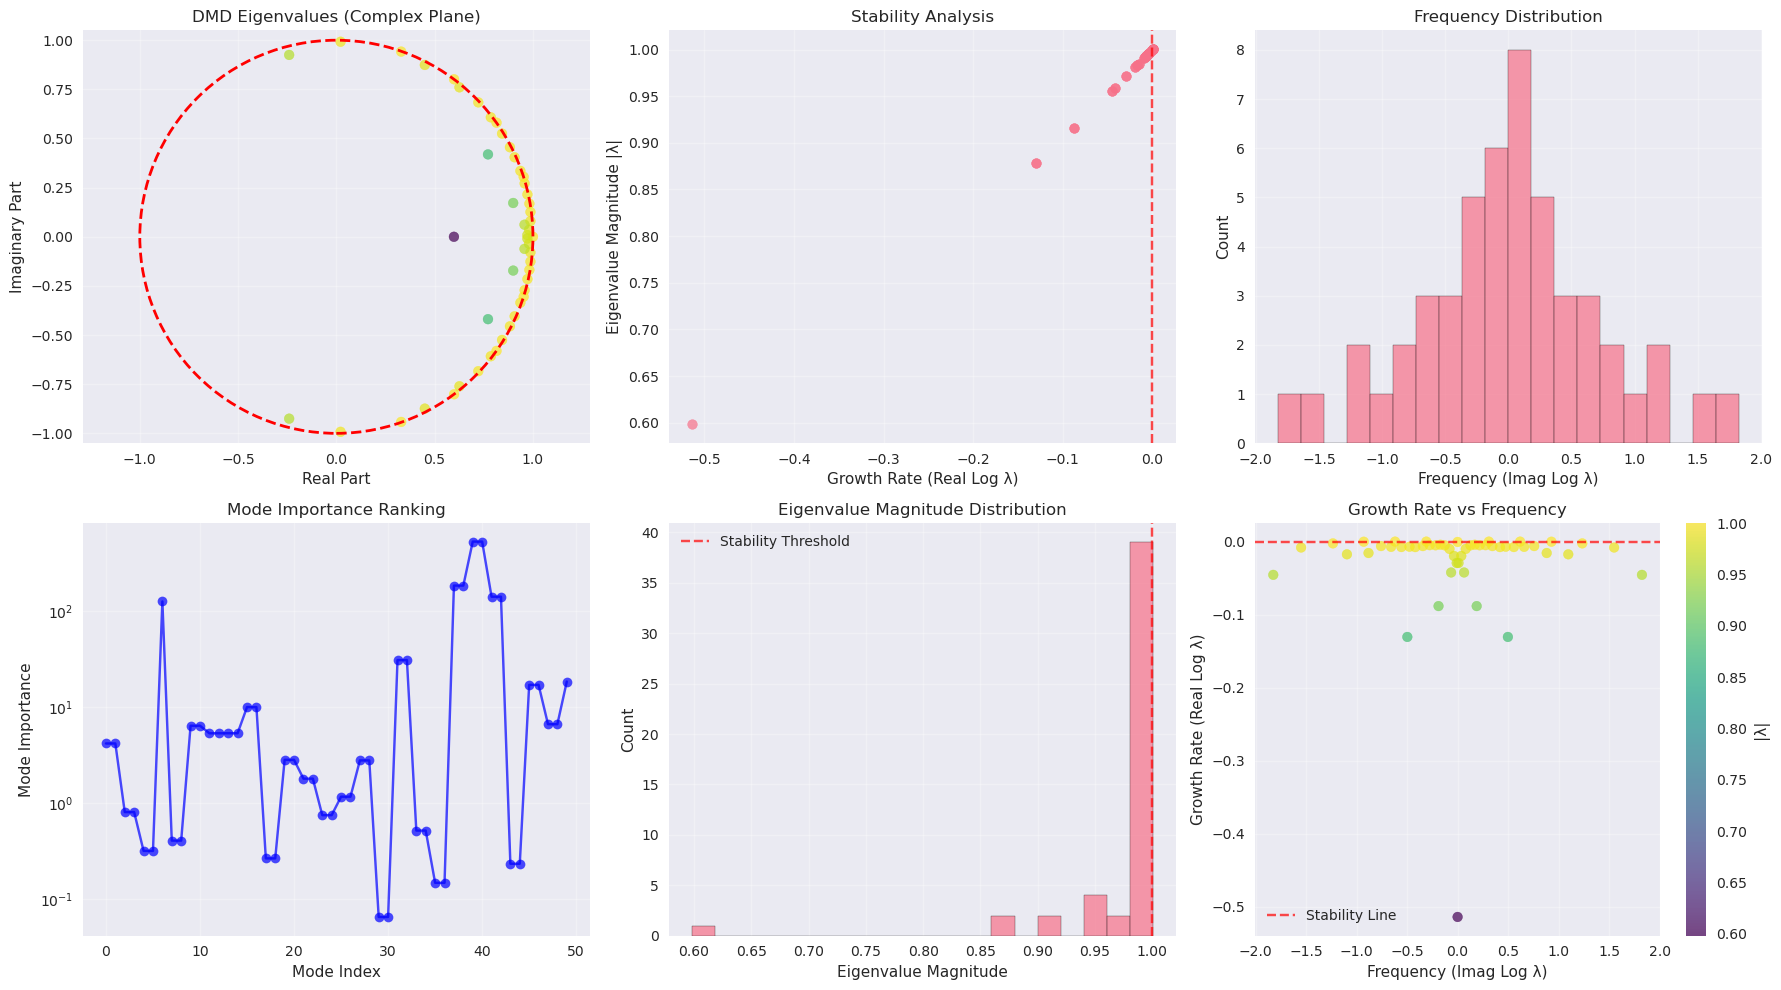

In [9]:
# Visualize eigenvalues analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Complex plane
axes[0, 0].scatter(eigenvalues.real, eigenvalues.imag, c=np.abs(eigenvalues), 
                   cmap='viridis', s=50, alpha=0.7)
axes[0, 0].add_patch(plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2))
axes[0, 0].set_xlabel('Real Part')
axes[0, 0].set_ylabel('Imaginary Part')
axes[0, 0].set_title('DMD Eigenvalues (Complex Plane)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axis('equal')

# Magnitude vs growth rate
axes[0, 1].scatter(growth_rates, np.abs(eigenvalues), alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_xlabel('Growth Rate (Real Log λ)')
axes[0, 1].set_ylabel('Eigenvalue Magnitude |λ|')
axes[0, 1].set_title('Stability Analysis')
axes[0, 1].grid(True, alpha=0.3)

# Frequency distribution
axes[0, 2].hist(frequencies, bins=20, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Frequency (Imag Log λ)')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Frequency Distribution')
axes[0, 2].grid(True, alpha=0.3)

# Mode importance
mode_importance = np.abs(amplitudes * eigenvalues)
axes[1, 0].semilogy(mode_importance, 'bo-', alpha=0.7)
axes[1, 0].set_xlabel('Mode Index')
axes[1, 0].set_ylabel('Mode Importance')
axes[1, 0].set_title('Mode Importance Ranking')
axes[1, 0].grid(True, alpha=0.3)

# Eigenvalue magnitude distribution
axes[1, 1].hist(np.abs(eigenvalues), bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Stability Threshold')
axes[1, 1].set_xlabel('Eigenvalue Magnitude')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Eigenvalue Magnitude Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Growth rate vs frequency
scatter = axes[1, 2].scatter(frequencies, growth_rates, c=np.abs(eigenvalues), 
                            cmap='viridis', alpha=0.7)
axes[1, 2].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Stability Line')
axes[1, 2].set_xlabel('Frequency (Imag Log λ)')
axes[1, 2].set_ylabel('Growth Rate (Real Log λ)')
axes[1, 2].set_title('Growth Rate vs Frequency')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 2], label='|λ|')

plt.tight_layout()
plt.show()

In [10]:
# Autoregressive prediction from x0
print(f"\nPerforming autoregressive prediction for {PREDICTION_STEPS} steps...")

# Use the first time step as initial condition
x0_normalized = sample_dmd_format[:, 0]

# Predict
pred_normalized = single_dmd.predict(PREDICTION_STEPS, x0=x0_normalized)

# Ground truth for comparison
gt_steps = min(PREDICTION_STEPS, sample_dmd_format.shape[1])
gt_normalized = sample_dmd_format[:, :gt_steps]

print(f"Prediction shape: {pred_normalized.shape}")
print(f"Ground truth shape: {gt_normalized.shape}")



Performing autoregressive prediction for 1000 steps...
Prediction shape: (8192, 1000)
Ground truth shape: (8192, 1000)


In [11]:
# Compute prediction errors
errors = single_dmd.compute_error(gt_normalized, pred_normalized[:, :gt_steps])
print(f"\nPrediction Errors (Normalized Data):")
for key, value in errors.items():
    print(f"  {key}: {value:.6f}")

# Denormalize for physical interpretation
gt_denorm_list = []
pred_denorm_list = []

for t in range(gt_steps):
    # Ground truth
    gt_t = gt_normalized[:, t].reshape(channels, spatial_features)
    gt_denorm_t = denormalize_cylinder_data(gt_t, train_dataset.mean, train_dataset.std)
    gt_denorm_list.append(gt_denorm_t.flatten())
    
    # Prediction
    pred_t = pred_normalized[:, t].reshape(channels, spatial_features)
    pred_denorm_t = denormalize_cylinder_data(pred_t, train_dataset.mean, train_dataset.std)
    pred_denorm_list.append(pred_denorm_t.flatten())

gt_denormalized = np.array(gt_denorm_list).T  # [features, time]
pred_denormalized = np.array(pred_denorm_list).T  # [features, time]

# Compute errors on denormalized data
mse_denorm = np.mean((gt_denormalized - pred_denormalized) ** 2)
rmse_denorm = np.sqrt(mse_denorm)
mae_denorm = np.mean(np.abs(gt_denormalized - pred_denormalized))

print(f"\nPrediction Errors (Denormalized Data):")
print(f"  MSE: {mse_denorm:.6f}")
print(f"  RMSE: {rmse_denorm:.6f}")
print(f"  MAE: {mae_denorm:.6f}")


Prediction Errors (Normalized Data):
  mse: 0.105705
  rmse: 0.325123
  mae: 0.179465
  relative_error: 0.225131

Prediction Errors (Denormalized Data):
  MSE: 0.313998
  RMSE: 0.560355
  MAE: 0.309159


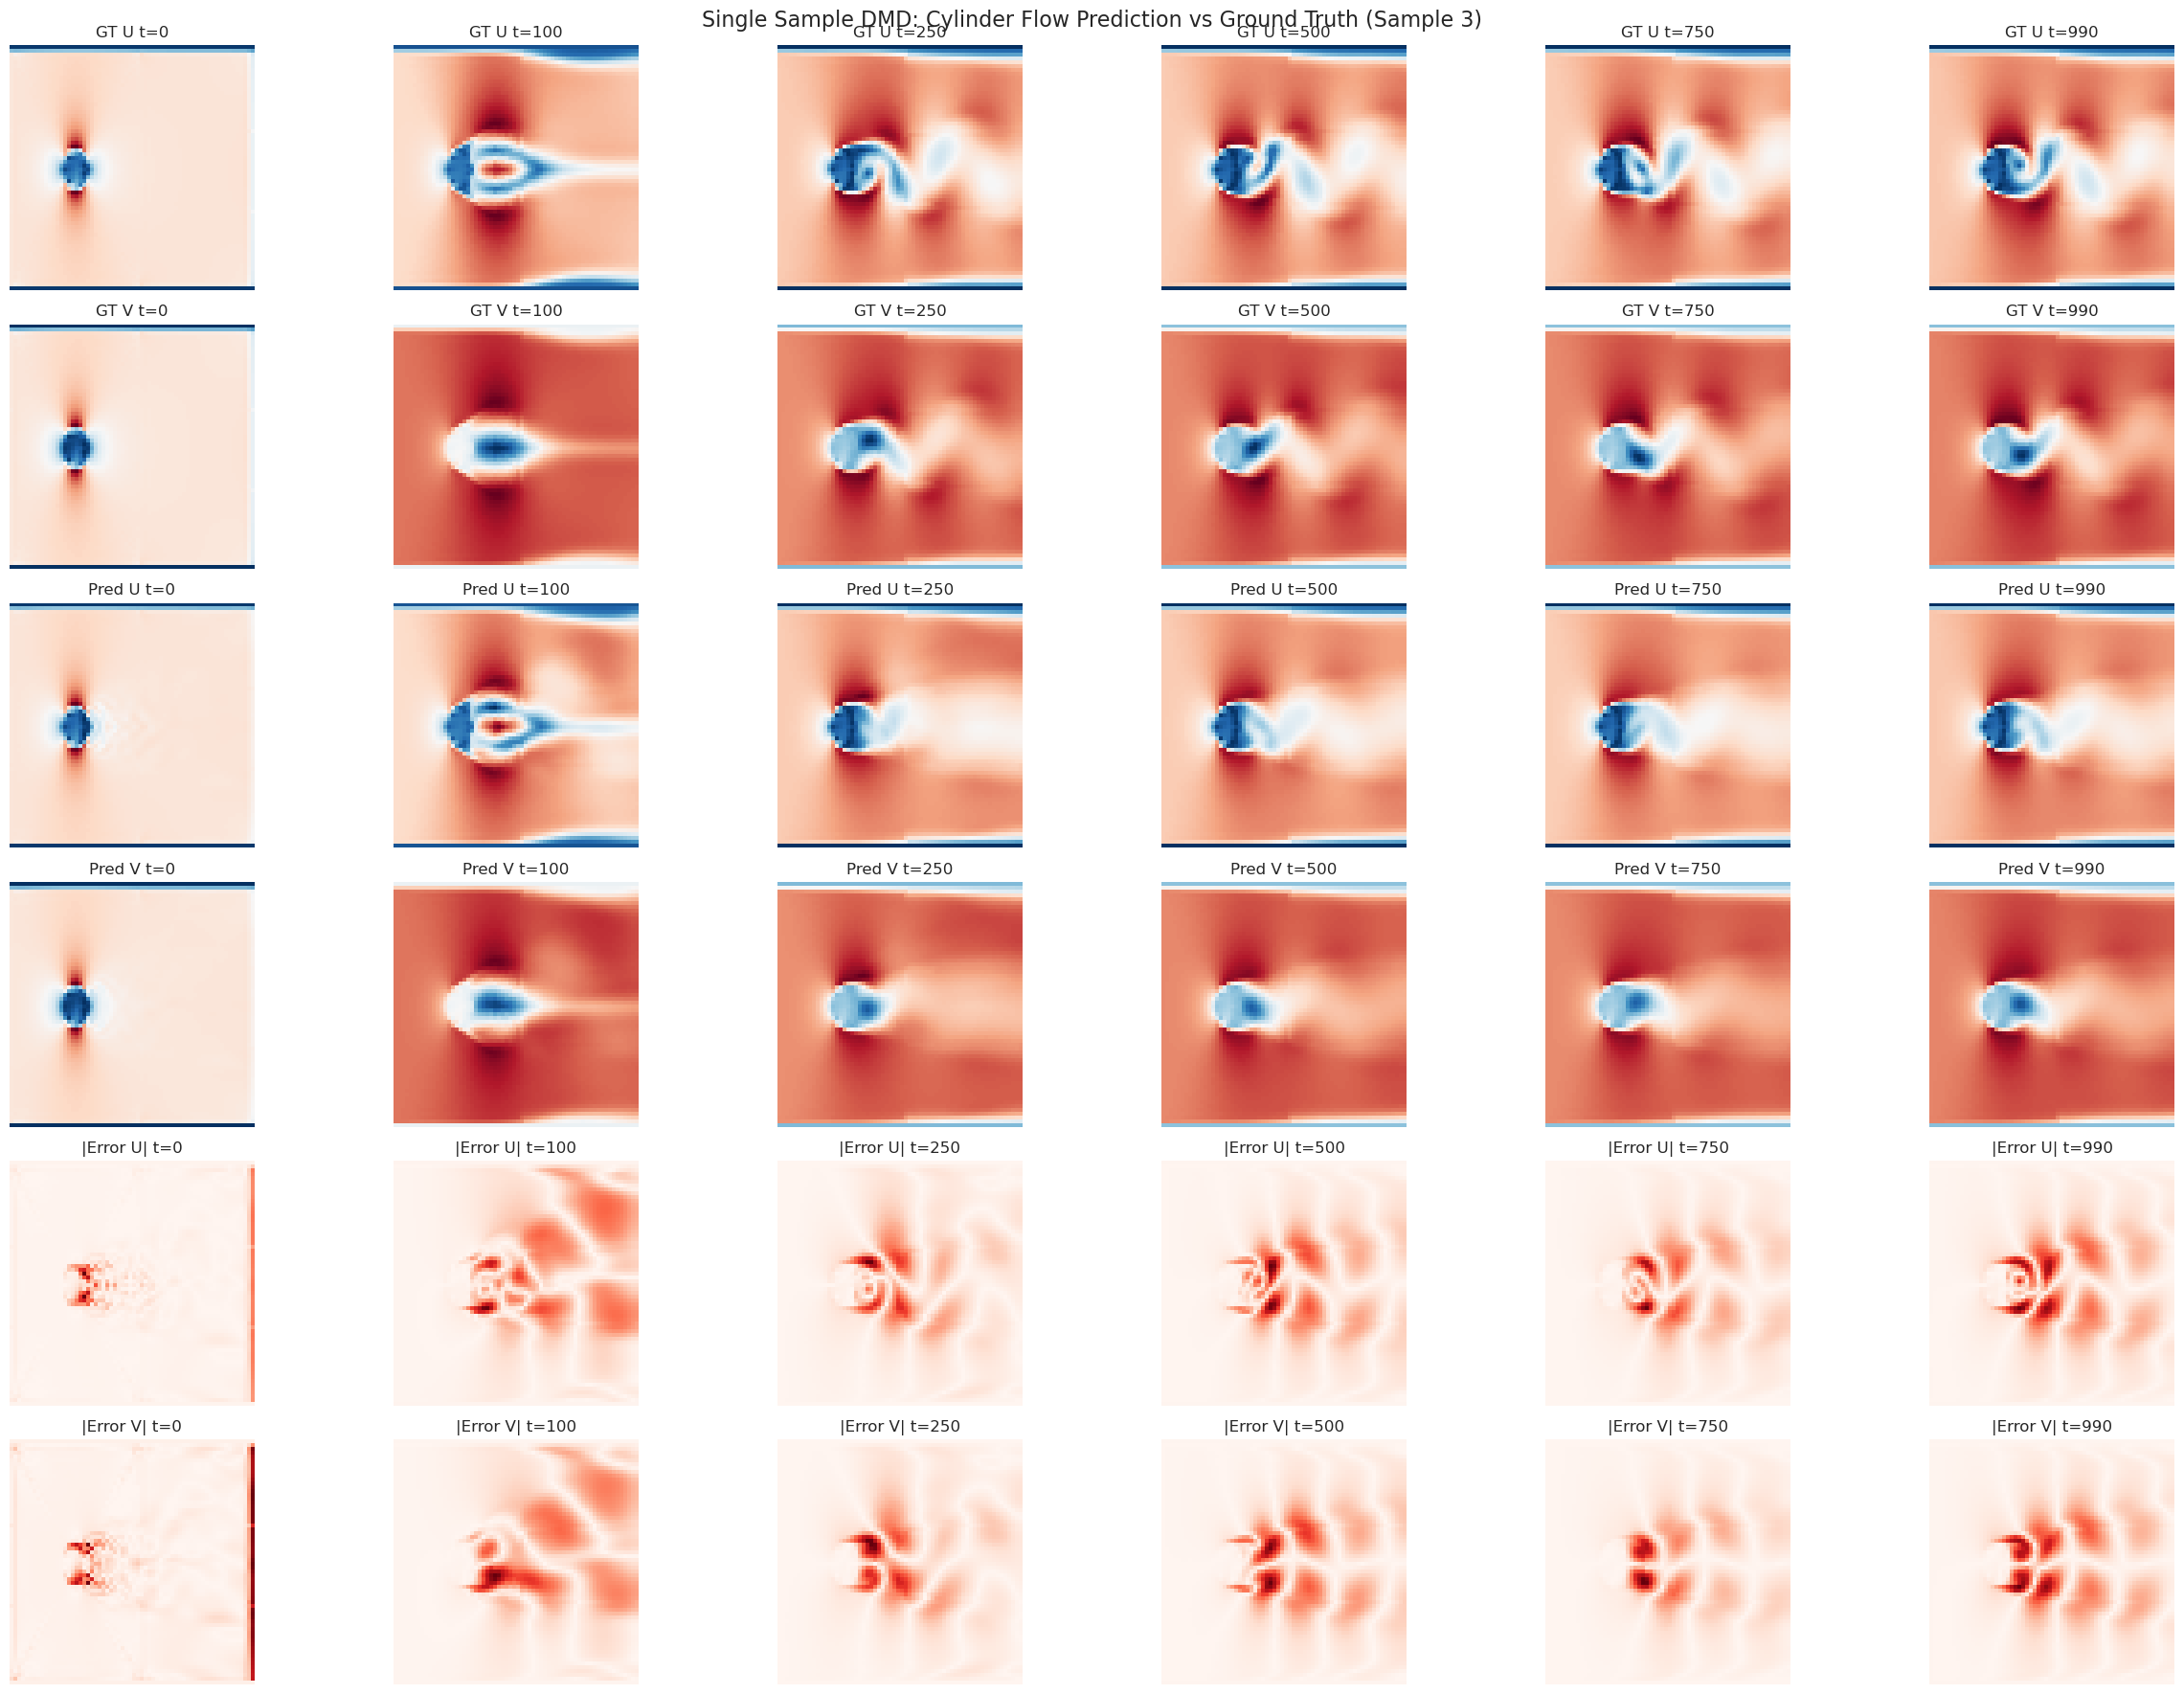

In [12]:
# Visualize prediction results - Flow fields at different time steps
time_points = [0, 100, 250, 500, 750, min(990, gt_steps-1)]
fig, axes = plt.subplots(6, len(time_points), figsize=(25, 18))

for i, t in enumerate(time_points):
    if t < gt_steps:
        # Ground truth
        gt_data = gt_denormalized[:, t].reshape(channels, height, width)
        gt_u = gt_data[0]
        gt_v = gt_data[1]
        gt_mag = np.sqrt(gt_u**2 + gt_v**2)
        
        # Prediction
        pred_data = pred_denormalized[:, t].reshape(channels, height, width)
        pred_u = pred_data[0]
        pred_v = pred_data[1]
        pred_mag = np.sqrt(pred_u**2 + pred_v**2)
        
        # Determine color scales
        u_vmin, u_vmax = min(gt_u.min(), pred_u.min()), max(gt_u.max(), pred_u.max())
        v_vmin, v_vmax = min(gt_v.min(), pred_v.min()), max(gt_v.max(), pred_v.max())
        mag_vmax = max(gt_mag.max(), pred_mag.max())
        
        # Ground truth u
        im1 = axes[0, i].imshow(gt_u, cmap='RdBu_r', vmin=u_vmin, vmax=u_vmax, 
                               aspect='equal', origin='lower')
        axes[0, i].set_title(f'GT U t={t}')
        axes[0, i].axis('off')
        
        # Ground truth v
        im2 = axes[1, i].imshow(gt_v, cmap='RdBu_r', vmin=v_vmin, vmax=v_vmax,
                               aspect='equal', origin='lower')
        axes[1, i].set_title(f'GT V t={t}')
        axes[1, i].axis('off')
        
        # Prediction u
        im3 = axes[2, i].imshow(pred_u, cmap='RdBu_r', vmin=u_vmin, vmax=u_vmax,
                               aspect='equal', origin='lower')
        axes[2, i].set_title(f'Pred U t={t}')
        axes[2, i].axis('off')
        
        # Prediction v
        im4 = axes[3, i].imshow(pred_v, cmap='RdBu_r', vmin=v_vmin, vmax=v_vmax,
                               aspect='equal', origin='lower')
        axes[3, i].set_title(f'Pred V t={t}')
        axes[3, i].axis('off')
        
        # Error u
        error_u = np.abs(gt_u - pred_u)
        im5 = axes[4, i].imshow(error_u, cmap='Reds', vmin=0, vmax=error_u.max(),
                               aspect='equal', origin='lower')
        axes[4, i].set_title(f'|Error U| t={t}')
        axes[4, i].axis('off')
        
        # Error v
        error_v = np.abs(gt_v - pred_v)
        im6 = axes[5, i].imshow(error_v, cmap='Reds', vmin=0, vmax=error_v.max(),
                               aspect='equal', origin='lower')
        axes[5, i].set_title(f'|Error V| t={t}')
        axes[5, i].axis('off')

plt.suptitle(f'Single Sample DMD: Cylinder Flow Prediction vs Ground Truth (Sample {SAMPLE_IDX})', fontsize=16)
plt.tight_layout()
plt.show()


Analyzing vorticity evolution...


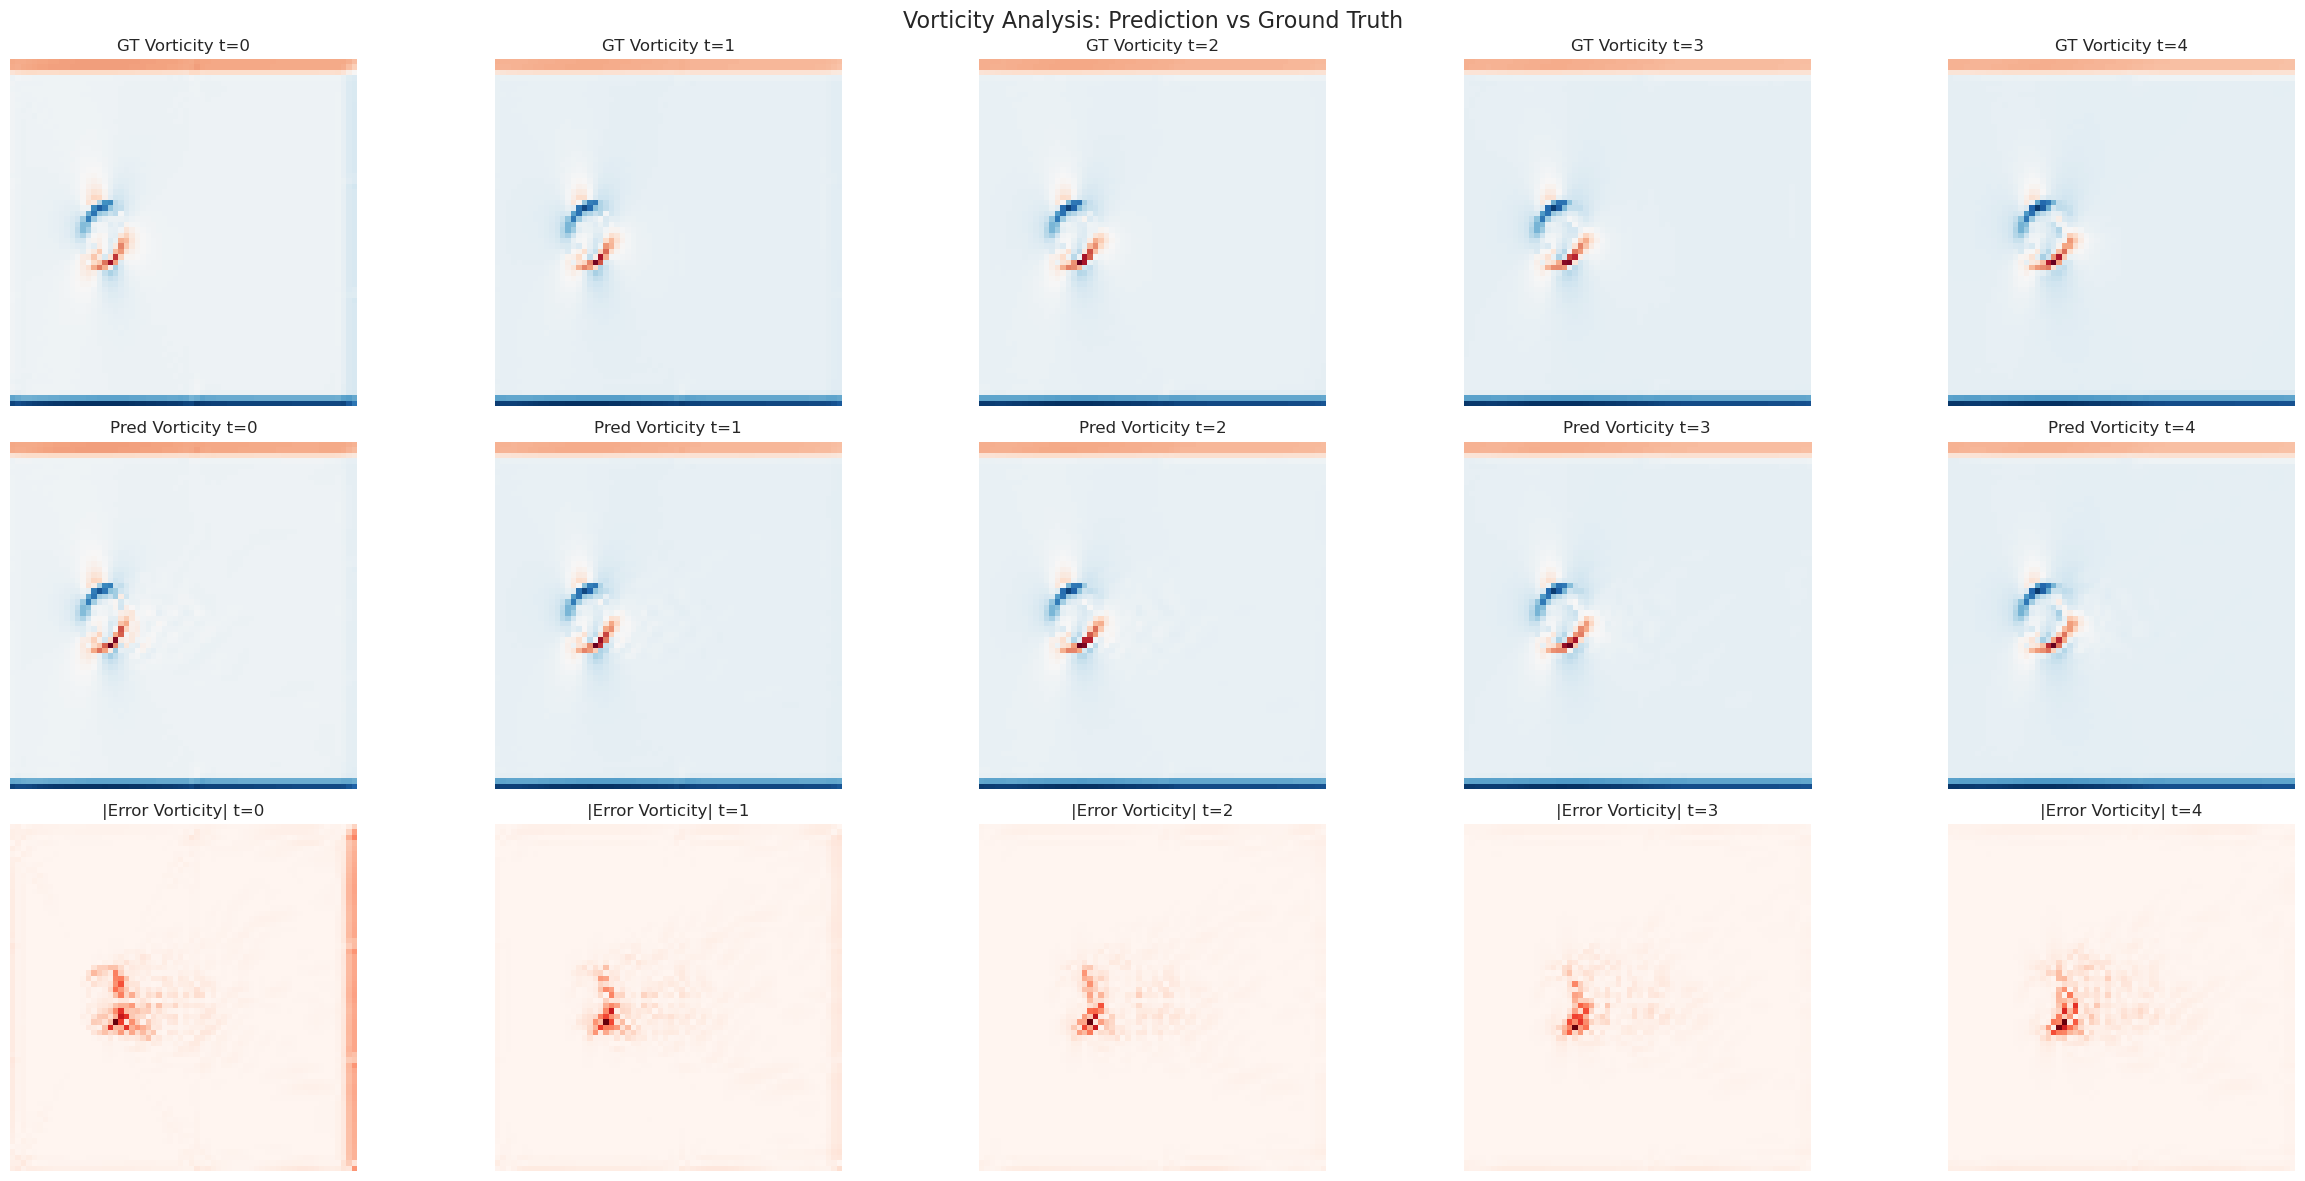

In [13]:
# Analyze vorticity evolution
print("\nAnalyzing vorticity evolution...")

vorticity_gt_list = []
vorticity_pred_list = []

for t in range(min(10, gt_steps)):  # First 10 time steps
    # Ground truth vorticity
    gt_data = gt_denormalized[:, t].reshape(channels, height, width)
    gt_vorticity = compute_vorticity(gt_data[0], gt_data[1])
    vorticity_gt_list.append(gt_vorticity)
    
    # Prediction vorticity
    pred_data = pred_denormalized[:, t].reshape(channels, height, width)
    pred_vorticity = compute_vorticity(pred_data[0], pred_data[1])
    vorticity_pred_list.append(pred_vorticity)

# Visualize vorticity comparison
fig, axes = plt.subplots(3, 5, figsize=(25, 12))

for i in range(5):
    if i < len(vorticity_gt_list):
        gt_vort = vorticity_gt_list[i]
        pred_vort = vorticity_pred_list[i]
        error_vort = np.abs(gt_vort - pred_vort)
        
        vort_vmin = min(gt_vort.min(), pred_vort.min())
        vort_vmax = max(gt_vort.max(), pred_vort.max())
        
        # Ground truth vorticity
        im1 = axes[0, i].imshow(gt_vort, cmap='RdBu_r', vmin=vort_vmin, vmax=vort_vmax,
                               aspect='equal', origin='lower')
        axes[0, i].set_title(f'GT Vorticity t={i}')
        axes[0, i].axis('off')
        
        # Prediction vorticity
        im2 = axes[1, i].imshow(pred_vort, cmap='RdBu_r', vmin=vort_vmin, vmax=vort_vmax,
                               aspect='equal', origin='lower')
        axes[1, i].set_title(f'Pred Vorticity t={i}')
        axes[1, i].axis('off')
        
        # Error
        im3 = axes[2, i].imshow(error_vort, cmap='Reds', vmin=0, vmax=error_vort.max(),
                               aspect='equal', origin='lower')
        axes[2, i].set_title(f'|Error Vorticity| t={i}')
        axes[2, i].axis('off')

plt.suptitle('Vorticity Analysis: Prediction vs Ground Truth', fontsize=16)
plt.tight_layout()
plt.show()

### [Extend] Single Sample DMD predict other sample

In [14]:
TEST_IDX = 33

sample_data = train_dataset.data[TEST_IDX]  # [time_steps, channels, spatial_features]
print(f"Selected sample shape: {sample_data.shape}")
print(f"Sample index: {TEST_IDX}")

# Reshape for DMD: flatten channels and spatial dimensions
time_steps, channels, spatial_features = sample_data.shape
sample_flattened = sample_data.reshape(time_steps, channels * spatial_features)

# Transpose to DMD format: [features, time_steps]
sample_dmd_format = sample_flattened.T
print(f"DMD format shape: {sample_dmd_format.shape}")

# Calculate spatial dimensions
total_features = channels * spatial_features
height, width = TARGET_RESOLUTION
print(f"Spatial resolution: {height} x {width}")
print(f"Channels: {channels} (u, v components)")

Selected sample shape: (1000, 2, 4096)
Sample index: 33
DMD format shape: (8192, 1000)
Spatial resolution: 64 x 64
Channels: 2 (u, v components)


In [15]:
# Autoregressive prediction from x0
print(f"\nPerforming autoregressive prediction for {PREDICTION_STEPS} steps...")

# Use the first time step as initial condition
x0_normalized = sample_dmd_format[:, 0]

# Predict
pred_normalized = single_dmd.predict(PREDICTION_STEPS, x0=x0_normalized)

# Ground truth for comparison
gt_steps = min(PREDICTION_STEPS, sample_dmd_format.shape[1])
gt_normalized = sample_dmd_format[:, :gt_steps]

print(f"Prediction shape: {pred_normalized.shape}")
print(f"Ground truth shape: {gt_normalized.shape}")


Performing autoregressive prediction for 1000 steps...
Prediction shape: (8192, 1000)
Ground truth shape: (8192, 1000)


In [16]:
# Compute prediction errors
errors = single_dmd.compute_error(gt_normalized, pred_normalized[:, :gt_steps])
print(f"\nPrediction Errors (Normalized Data):")
for key, value in errors.items():
    print(f"  {key}: {value:.6f}")

# Denormalize for physical interpretation
gt_denorm_list = []
pred_denorm_list = []

for t in range(gt_steps):
    # Ground truth
    gt_t = gt_normalized[:, t].reshape(channels, spatial_features)
    gt_denorm_t = denormalize_cylinder_data(gt_t, train_dataset.mean, train_dataset.std)
    gt_denorm_list.append(gt_denorm_t.flatten())
    
    # Prediction
    pred_t = pred_normalized[:, t].reshape(channels, spatial_features)
    pred_denorm_t = denormalize_cylinder_data(pred_t, train_dataset.mean, train_dataset.std)
    pred_denorm_list.append(pred_denorm_t.flatten())

gt_denormalized = np.array(gt_denorm_list).T  # [features, time]
pred_denormalized = np.array(pred_denorm_list).T  # [features, time]

# Compute errors on denormalized data
mse_denorm = np.mean((gt_denormalized - pred_denormalized) ** 2)
rmse_denorm = np.sqrt(mse_denorm)
mae_denorm = np.mean(np.abs(gt_denormalized - pred_denormalized))

print(f"\nPrediction Errors (Denormalized Data):")
print(f"  MSE: {mse_denorm:.6f}")
print(f"  RMSE: {rmse_denorm:.6f}")
print(f"  MAE: {mae_denorm:.6f}")


Prediction Errors (Normalized Data):
  mse: 0.267944
  rmse: 0.517633
  mae: 0.328394
  relative_error: 1.051165

Prediction Errors (Denormalized Data):
  MSE: 0.796950
  RMSE: 0.892721
  MAE: 0.565894


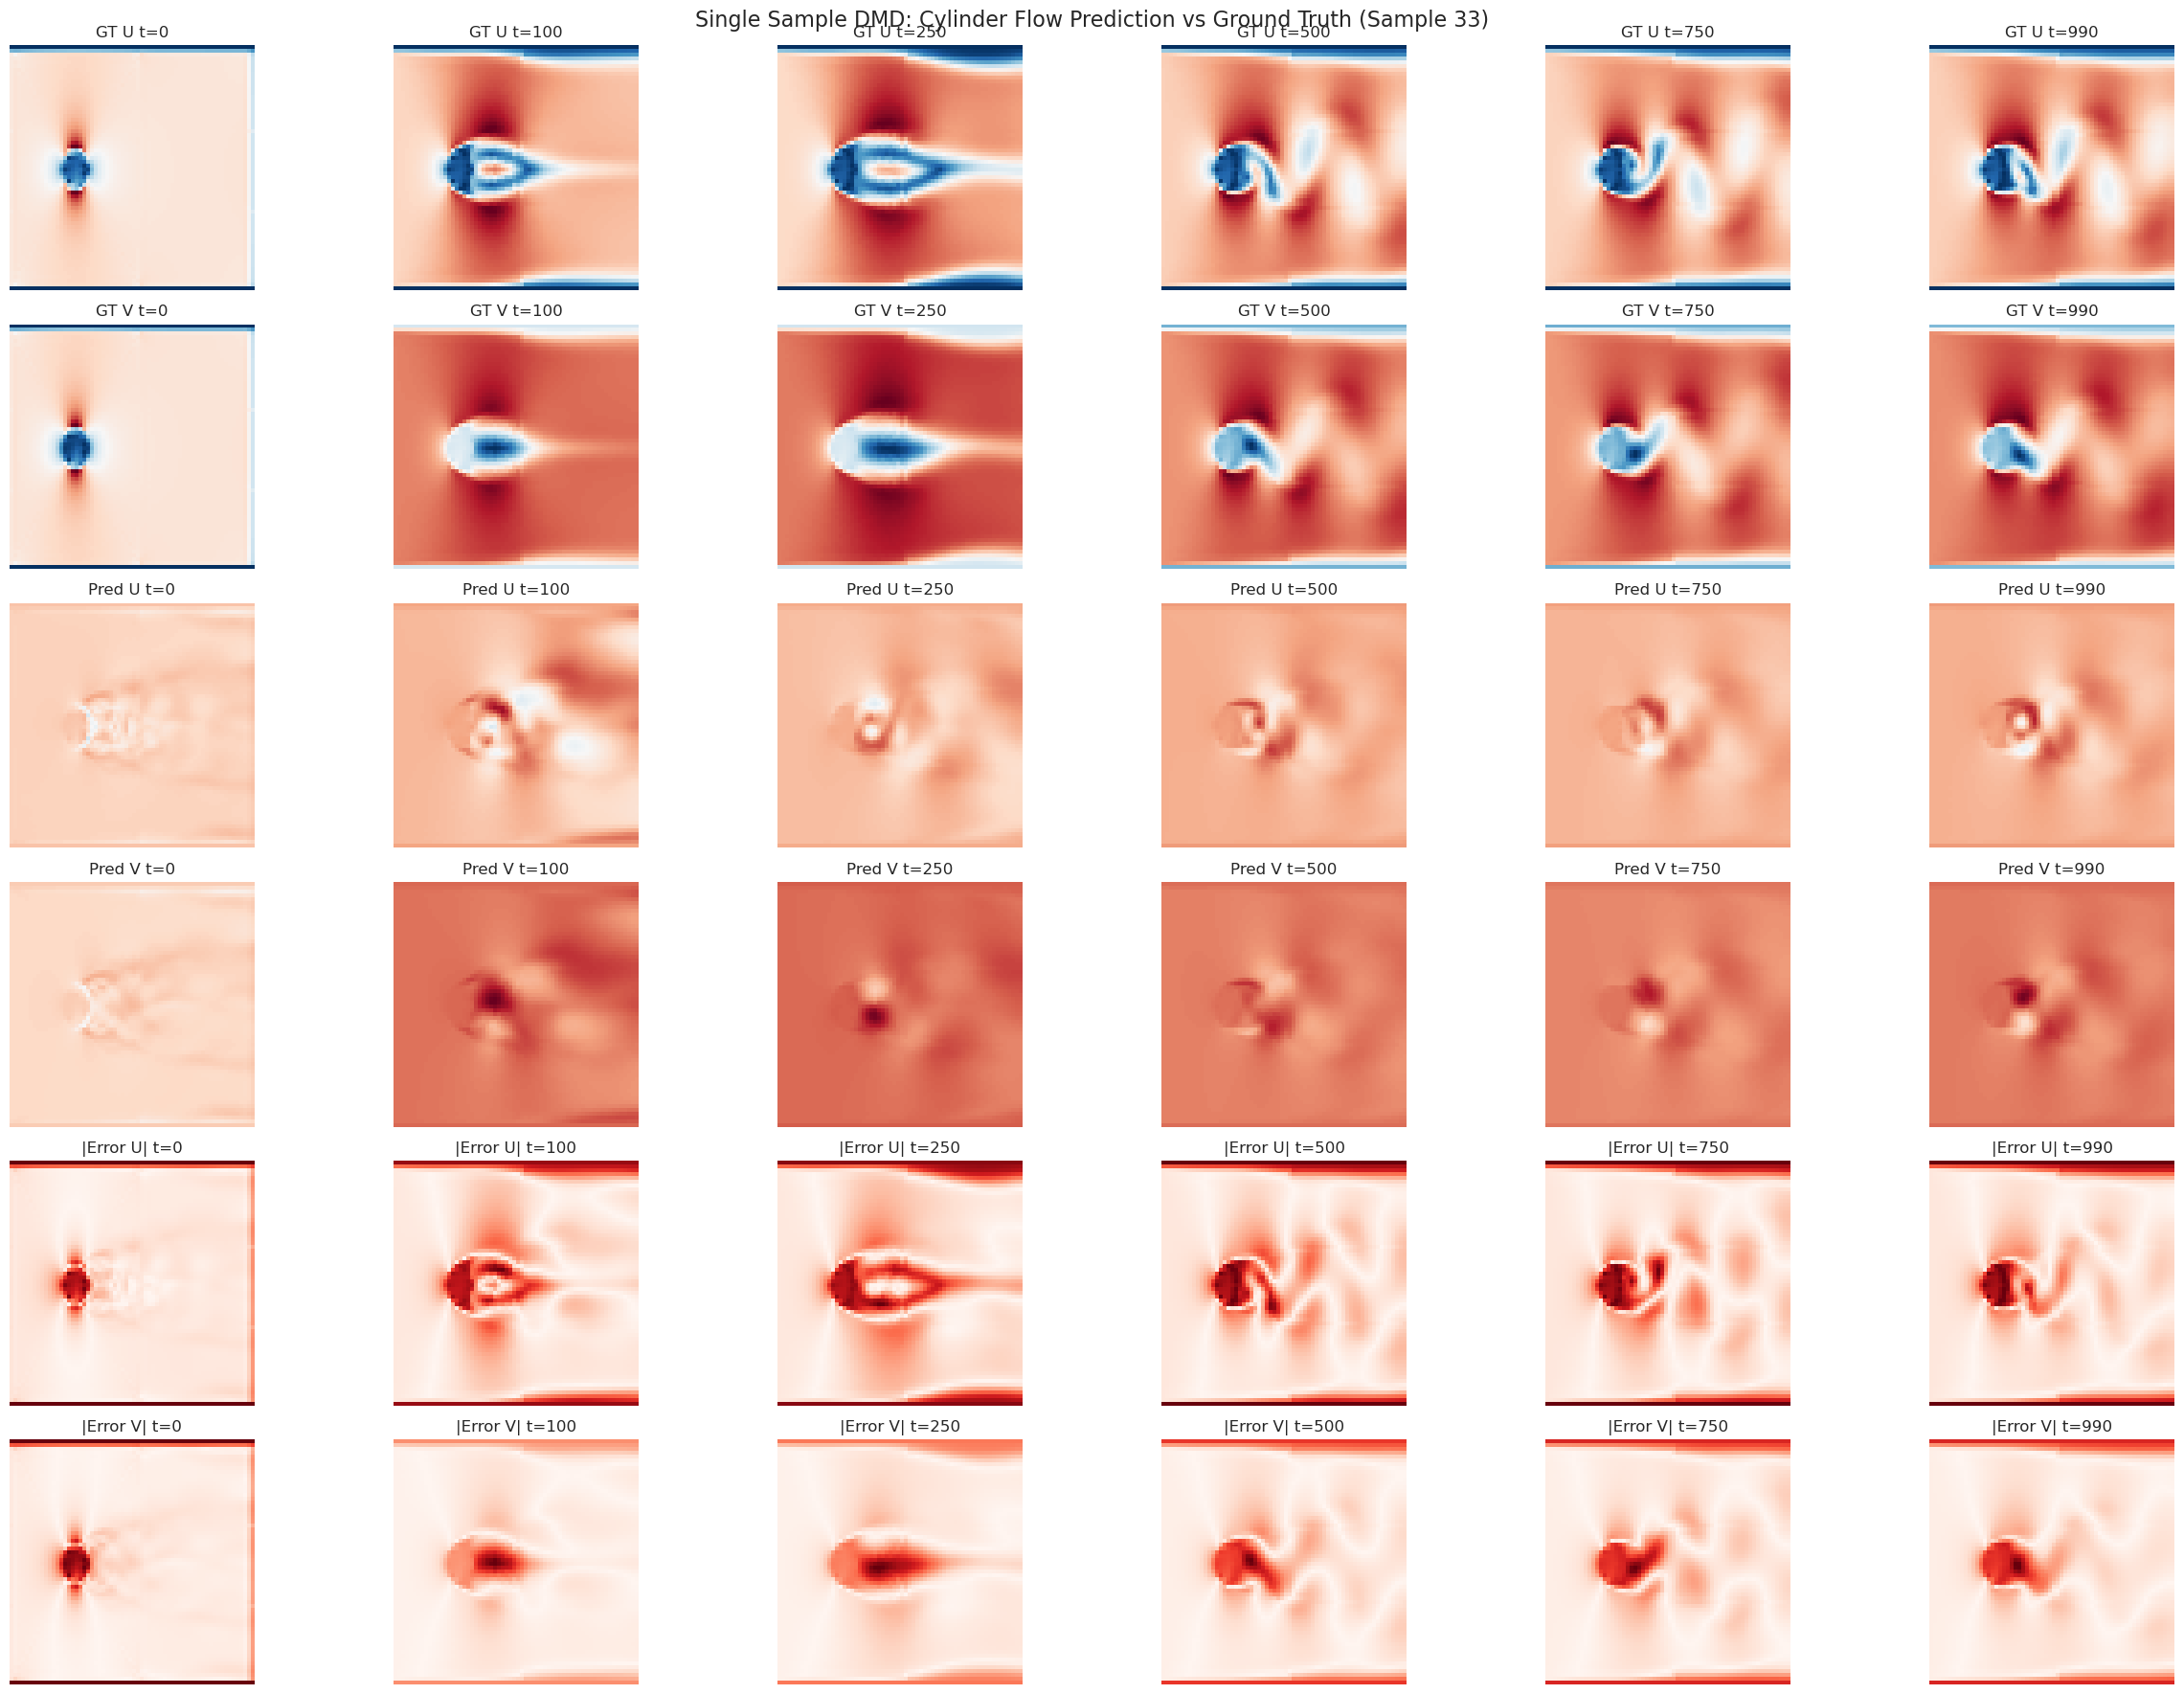

In [17]:
# Visualize prediction results - Flow fields at different time steps
time_points = [0, 100, 250, 500, 750, min(990, gt_steps-1)]
fig, axes = plt.subplots(6, len(time_points), figsize=(25, 18))

for i, t in enumerate(time_points):
    if t < gt_steps:
        # Ground truth
        gt_data = gt_denormalized[:, t].reshape(channels, height, width)
        gt_u = gt_data[0]
        gt_v = gt_data[1]
        gt_mag = np.sqrt(gt_u**2 + gt_v**2)
        
        # Prediction
        pred_data = pred_denormalized[:, t].reshape(channels, height, width)
        pred_u = pred_data[0]
        pred_v = pred_data[1]
        pred_mag = np.sqrt(pred_u**2 + pred_v**2)
        
        # Determine color scales
        u_vmin, u_vmax = min(gt_u.min(), pred_u.min()), max(gt_u.max(), pred_u.max())
        v_vmin, v_vmax = min(gt_v.min(), pred_v.min()), max(gt_v.max(), pred_v.max())
        mag_vmax = max(gt_mag.max(), pred_mag.max())
        
        # Ground truth u
        im1 = axes[0, i].imshow(gt_u, cmap='RdBu_r', vmin=u_vmin, vmax=u_vmax, 
                               aspect='equal', origin='lower')
        axes[0, i].set_title(f'GT U t={t}')
        axes[0, i].axis('off')
        
        # Ground truth v
        im2 = axes[1, i].imshow(gt_v, cmap='RdBu_r', vmin=v_vmin, vmax=v_vmax,
                               aspect='equal', origin='lower')
        axes[1, i].set_title(f'GT V t={t}')
        axes[1, i].axis('off')
        
        # Prediction u
        im3 = axes[2, i].imshow(pred_u, cmap='RdBu_r', vmin=u_vmin, vmax=u_vmax,
                               aspect='equal', origin='lower')
        axes[2, i].set_title(f'Pred U t={t}')
        axes[2, i].axis('off')
        
        # Prediction v
        im4 = axes[3, i].imshow(pred_v, cmap='RdBu_r', vmin=v_vmin, vmax=v_vmax,
                               aspect='equal', origin='lower')
        axes[3, i].set_title(f'Pred V t={t}')
        axes[3, i].axis('off')
        
        # Error u
        error_u = np.abs(gt_u - pred_u)
        im5 = axes[4, i].imshow(error_u, cmap='Reds', vmin=0, vmax=error_u.max(),
                               aspect='equal', origin='lower')
        axes[4, i].set_title(f'|Error U| t={t}')
        axes[4, i].axis('off')
        
        # Error v
        error_v = np.abs(gt_v - pred_v)
        im6 = axes[5, i].imshow(error_v, cmap='Reds', vmin=0, vmax=error_v.max(),
                               aspect='equal', origin='lower')
        axes[5, i].set_title(f'|Error V| t={t}')
        axes[5, i].axis('off')

plt.suptitle(f'Single Sample DMD: Cylinder Flow Prediction vs Ground Truth (Sample {TEST_IDX})', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Large Sample DMD Analysis

In [18]:
print("="*60)
print("PART 2: LARGE SAMPLE DMD ANALYSIS")
print("="*60)

# Find the large DMD model for cylinder
model_files = list(Path(MODEL_PATH).glob("dmd_cylinder*.npz"))
if not model_files:
    print("No large Cylinder DMD model found! Please run large_train.py first.")
    print("Expected model path:", MODEL_PATH)
else:
    # Use the first found model
    model_file = model_files[0]
    print(f"Found DMD model: {model_file}")
    
    # Load metadata if available
    metadata_file = '../../results/checkpoints/DMD/dmd_cylinder_rank100_exact_metadata.json'
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    print("Model metadata:")
    print(f"  Training time: {metadata.get('training_time', 'N/A')} seconds")
    print(f"  Data shape: {metadata.get('data_shape', 'N/A')}")
    if 'model_info' in metadata:
        model_info = metadata['model_info']
        print(f"  Number of modes: {model_info.get('n_modes', 'N/A')}")
        print(f"  Stable modes: {model_info.get('stable_modes', 'N/A')}")
        print(f"  Unstable modes: {model_info.get('unstable_modes', 'N/A')}")

PART 2: LARGE SAMPLE DMD ANALYSIS
Found DMD model: ../../results/checkpoints/DMD/dmd_cylinder_rank100_exact.npz
Model metadata:
  Training time: 3484.4044342041016 seconds
  Data shape: [8192, 39000]
  Number of modes: 100
  Stable modes: 99
  Unstable modes: 1


In [19]:
# Load the large DMD model
large_dmd = DMD()
large_dmd.load(str(model_file))

print("Large Cylinder DMD model loaded successfully!")
print(f"Model fitted: {large_dmd._fitted}")

# Get DMD components
large_modes, large_eigenvalues, large_amplitudes = large_dmd.get_mode_dynamics()

print(f"\nLarge Sample DMD Results:")
print(f"  Number of modes: {large_modes.shape[1]}")
print(f"  Data dimensions: {large_modes.shape[0]}")
print(f"  Eigenvalue magnitudes (top 10): {np.abs(large_eigenvalues[:10])}")

# Analyze eigenvalues
large_growth_rates = np.real(np.log(large_eigenvalues))
large_frequencies = np.imag(np.log(large_eigenvalues))
large_stable_modes = np.sum(large_growth_rates <= 0)
large_unstable_modes = np.sum(large_growth_rates > 0)

print(f"  Stable modes: {large_stable_modes}")
print(f"  Unstable modes: {large_unstable_modes}")
print(f"  Growth rates range: [{large_growth_rates.min():.4f}, {large_growth_rates.max():.4f}]")
print(f"  Frequencies range: [{large_frequencies.min():.4f}, {large_frequencies.max():.4f}]")

Large Cylinder DMD model loaded successfully!
Model fitted: True

Large Sample DMD Results:
  Number of modes: 100
  Data dimensions: 8192
  Eigenvalue magnitudes (top 10): [1.00000008 0.99988657 0.99959546 0.99943983 0.99813325 0.99802351
 0.99802351 0.99725416 0.99725416 0.99710113]
  Stable modes: 99
  Unstable modes: 1
  Growth rates range: [-0.1164, 0.0000]
  Frequencies range: [-0.3165, 0.3165]


In [20]:
# Select a random sample from validation set for prediction
val_sample_idx = np.random.randint(0, len(val_dataset.data))
val_sample = val_dataset.data[val_sample_idx]  # [time_steps, channels, spatial_features]

print(f"Selected validation sample index: {val_sample_idx}")
print(f"Validation sample shape: {val_sample.shape}")

# Convert to DMD format
val_time_steps, val_channels, val_spatial_features = val_sample.shape
val_sample_flattened = val_sample.reshape(val_time_steps, val_channels * val_spatial_features)
val_sample_dmd = val_sample_flattened.T  # [features, time_steps]

# Use first time step as initial condition
val_x0_normalized = val_sample_dmd[:, 0]

print(f"Initial condition shape: {val_x0_normalized.shape}")

Selected validation sample index: 9
Validation sample shape: (1000, 2, 4096)
Initial condition shape: (8192,)


In [21]:
# Predict using large DMD model
print(f"Performing large DMD prediction for {PREDICTION_STEPS} steps...")

large_pred_normalized = large_dmd.predict(PREDICTION_STEPS, x0=val_x0_normalized)

# Ground truth for comparison
val_gt_steps = min(PREDICTION_STEPS, val_sample_dmd.shape[1])
val_gt_normalized = val_sample_dmd[:, :val_gt_steps]

print(f"Large prediction shape: {large_pred_normalized.shape}")
print(f"Validation ground truth shape: {val_gt_normalized.shape}")

Performing large DMD prediction for 1000 steps...
Large prediction shape: (8192, 1000)
Validation ground truth shape: (8192, 1000)


In [22]:
# Compute prediction errors for large DMD
large_errors = large_dmd.compute_error(val_gt_normalized, large_pred_normalized[:, :val_gt_steps])
print(f"\nLarge DMD Prediction Errors (Normalized Data):")
for key, value in large_errors.items():
    print(f"  {key}: {value:.6f}")

# Denormalize for physical interpretation
val_gt_denorm_list = []
large_pred_denorm_list = []

for t in range(val_gt_steps):
    # Ground truth
    val_gt_t = val_gt_normalized[:, t].reshape(val_channels, val_spatial_features)
    val_gt_denorm_t = denormalize_cylinder_data(val_gt_t, train_dataset.mean, train_dataset.std)
    val_gt_denorm_list.append(val_gt_denorm_t.flatten())
    
    # Prediction
    large_pred_t = large_pred_normalized[:, t].reshape(val_channels, val_spatial_features)
    large_pred_denorm_t = denormalize_cylinder_data(large_pred_t, train_dataset.mean, train_dataset.std)
    large_pred_denorm_list.append(large_pred_denorm_t.flatten())

val_gt_denormalized = np.array(val_gt_denorm_list).T  # [features, time]
large_pred_denormalized = np.array(large_pred_denorm_list).T  # [features, time]

# Compute errors on denormalized data
large_mse_denorm = np.mean((val_gt_denormalized - large_pred_denormalized) ** 2)
large_rmse_denorm = np.sqrt(large_mse_denorm)
large_mae_denorm = np.mean(np.abs(val_gt_denormalized - large_pred_denormalized))

print(f"\nLarge DMD Prediction Errors (Denormalized Data):")
print(f"  MSE: {large_mse_denorm:.6f}")
print(f"  RMSE: {large_rmse_denorm:.6f}")
print(f"  MAE: {large_mae_denorm:.6f}")


Large DMD Prediction Errors (Normalized Data):
  mse: 17.245656
  rmse: 4.152789
  mae: 3.955854
  relative_error: 1.002076

Large DMD Prediction Errors (Denormalized Data):
  MSE: 51.164310
  RMSE: 7.152923
  MAE: 6.813654


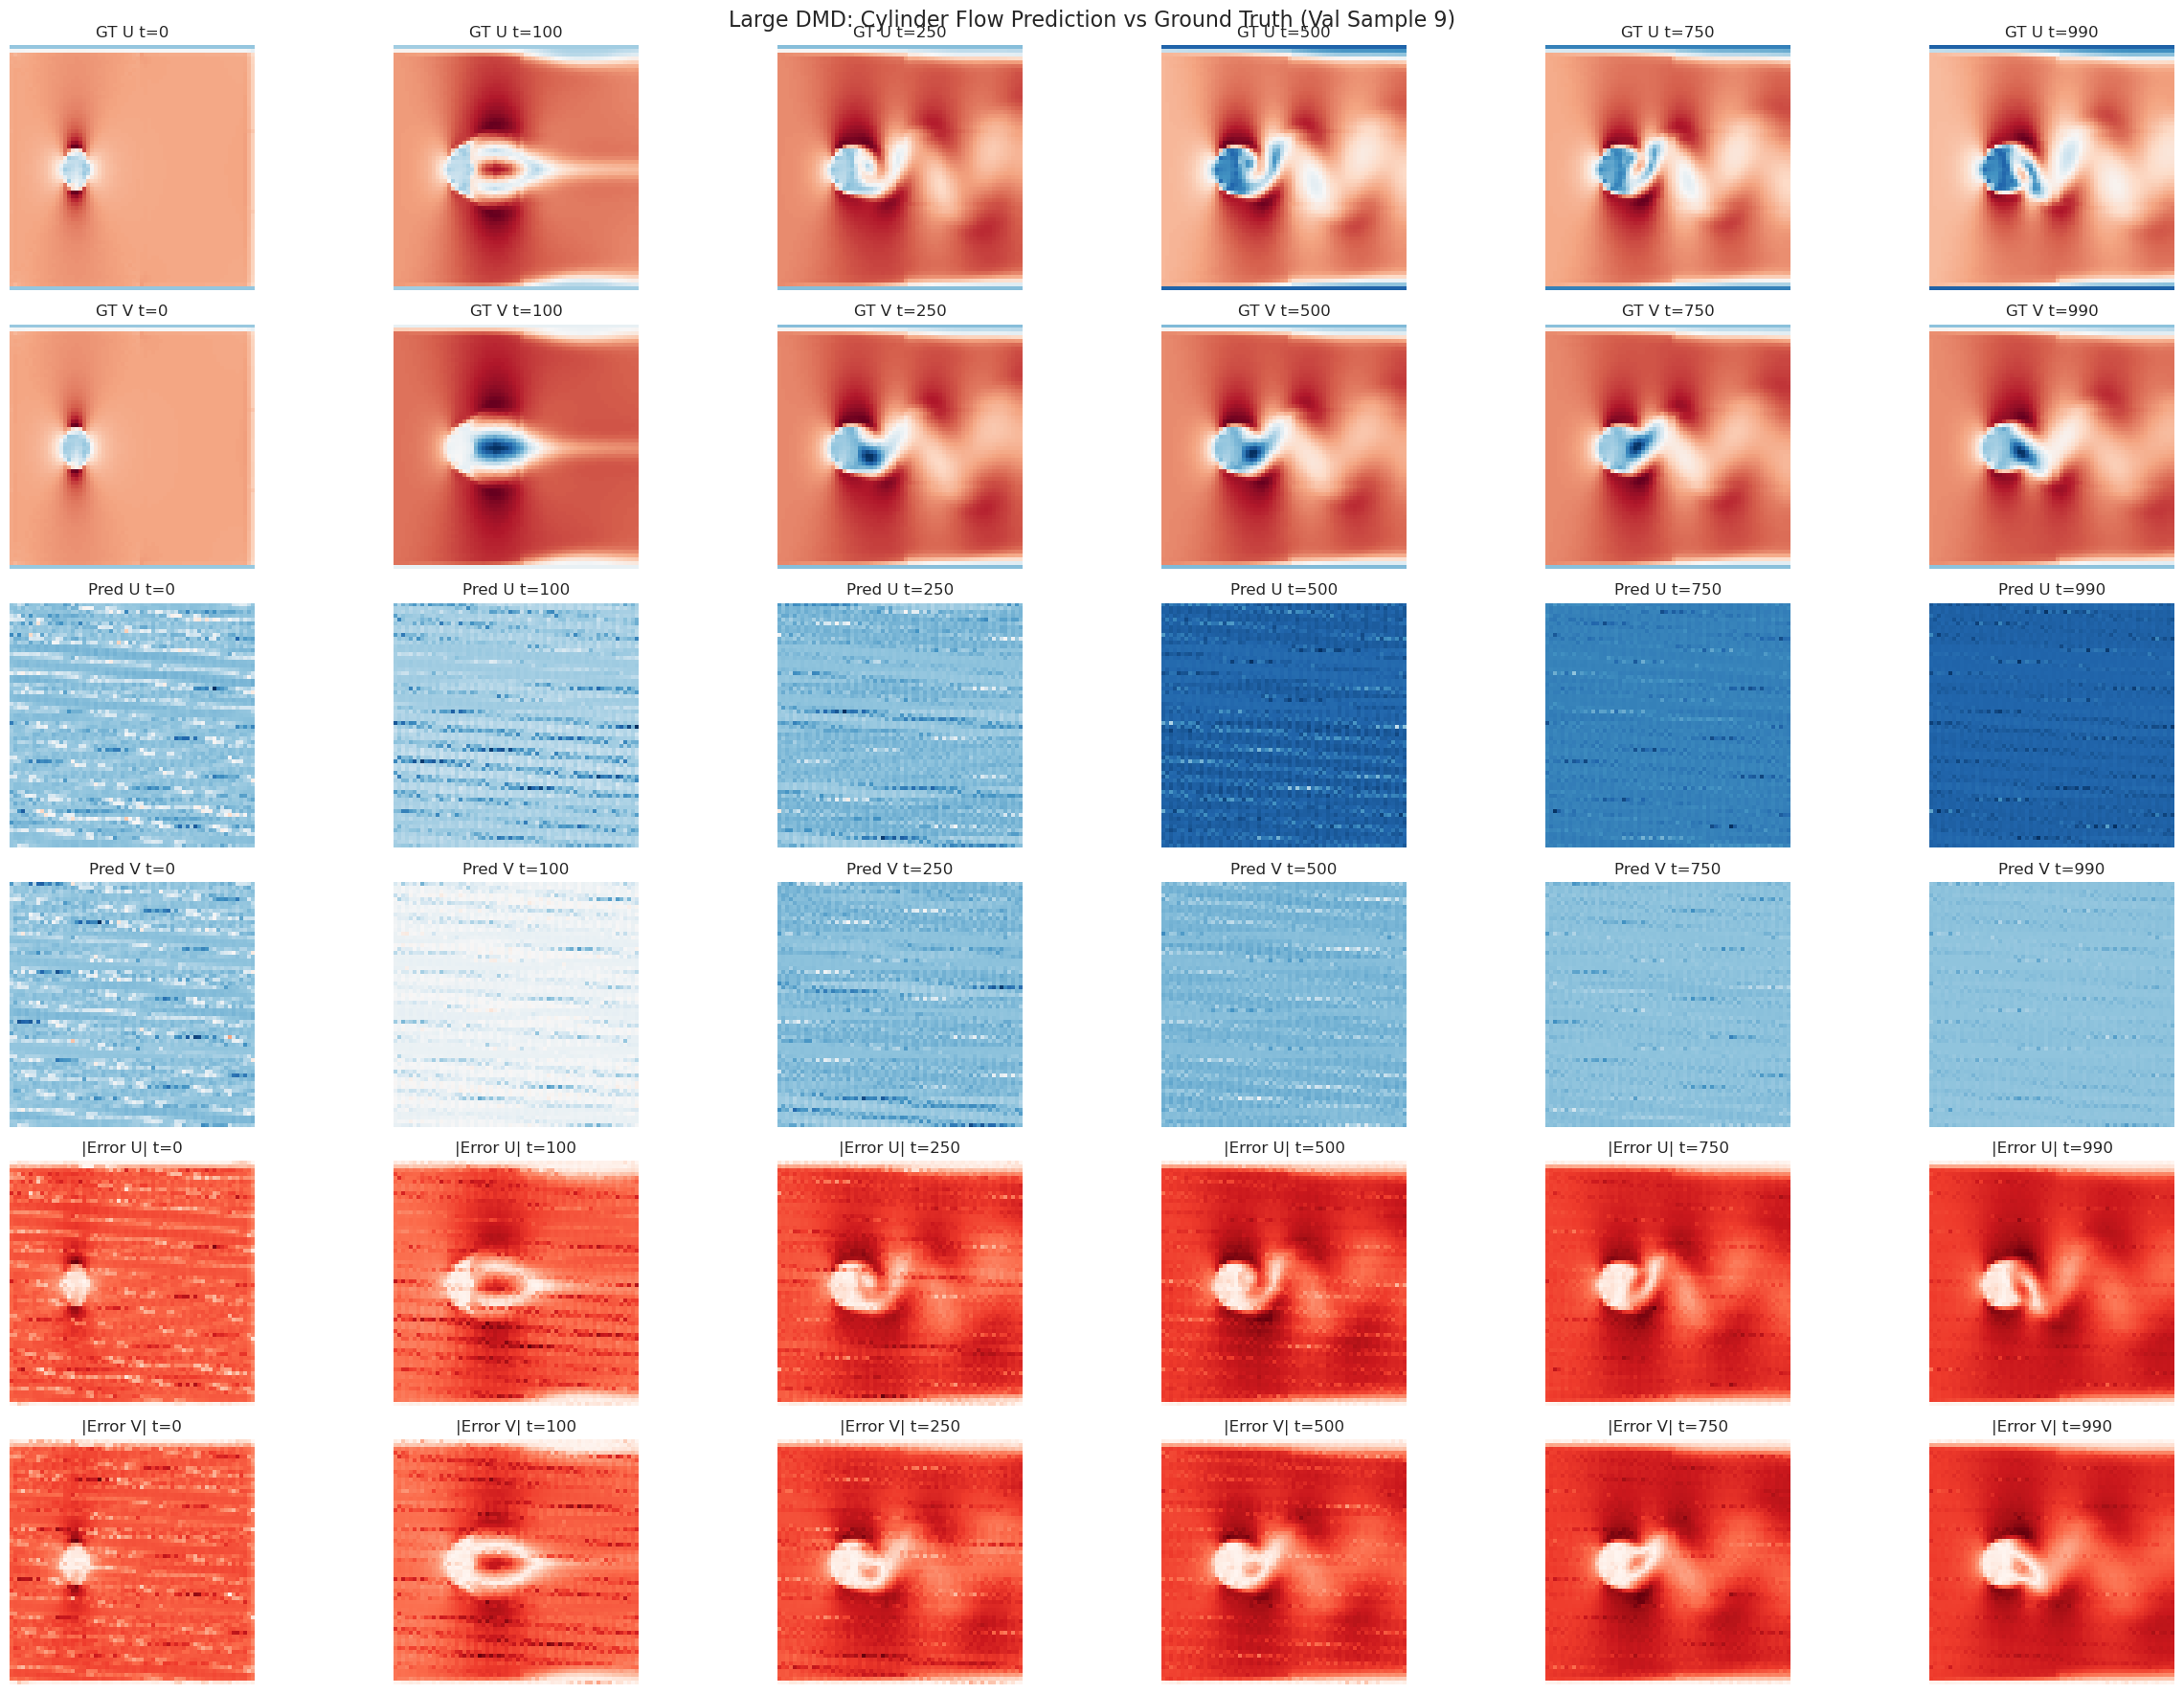

In [23]:
# Visualize large DMD prediction results
time_points = [0, 100, 250, 500, 750, min(990, val_gt_steps-1)]
fig, axes = plt.subplots(6, len(time_points), figsize=(25, 18))

for i, t in enumerate(time_points):
    if t < val_gt_steps:
        # Ground truth
        val_gt_data = val_gt_denormalized[:, t].reshape(val_channels, height, width)
        val_gt_u = val_gt_data[0]
        val_gt_v = val_gt_data[1]
        
        # Prediction
        large_pred_data = large_pred_denormalized[:, t].reshape(val_channels, height, width)
        large_pred_u = large_pred_data[0]
        large_pred_v = large_pred_data[1]
        
        # Determine color scales
        u_vmin = min(val_gt_u.min(), large_pred_u.min())
        u_vmax = max(val_gt_u.max(), large_pred_u.max())
        v_vmin = min(val_gt_v.min(), large_pred_v.min())
        v_vmax = max(val_gt_v.max(), large_pred_v.max())
        
        # Ground truth u
        im1 = axes[0, i].imshow(val_gt_u, cmap='RdBu_r', vmin=u_vmin, vmax=u_vmax,
                               aspect='equal', origin='lower')
        axes[0, i].set_title(f'GT U t={t}')
        axes[0, i].axis('off')
        
        # Ground truth v
        im2 = axes[1, i].imshow(val_gt_v, cmap='RdBu_r', vmin=v_vmin, vmax=v_vmax,
                               aspect='equal', origin='lower')
        axes[1, i].set_title(f'GT V t={t}')
        axes[1, i].axis('off')
        
        # Prediction u
        im3 = axes[2, i].imshow(large_pred_u, cmap='RdBu_r', vmin=u_vmin, vmax=u_vmax,
                               aspect='equal', origin='lower')
        axes[2, i].set_title(f'Pred U t={t}')
        axes[2, i].axis('off')
        
        # Prediction v
        im4 = axes[3, i].imshow(large_pred_v, cmap='RdBu_r', vmin=v_vmin, vmax=v_vmax,
                               aspect='equal', origin='lower')
        axes[3, i].set_title(f'Pred V t={t}')
        axes[3, i].axis('off')
        
        # Error u
        val_error_u = np.abs(val_gt_u - large_pred_u)
        im5 = axes[4, i].imshow(val_error_u, cmap='Reds', vmin=0, vmax=val_error_u.max(),
                               aspect='equal', origin='lower')
        axes[4, i].set_title(f'|Error U| t={t}')
        axes[4, i].axis('off')
        
        # Error v
        val_error_v = np.abs(val_gt_v - large_pred_v)
        im6 = axes[5, i].imshow(val_error_v, cmap='Reds', vmin=0, vmax=val_error_v.max(),
                               aspect='equal', origin='lower')
        axes[5, i].set_title(f'|Error V| t={t}')
        axes[5, i].axis('off')

plt.suptitle(f'Large DMD: Cylinder Flow Prediction vs Ground Truth (Val Sample {val_sample_idx})', fontsize=16)
plt.tight_layout()
plt.show()

## 4. DMD Mode Analysis for Cylinder Flow

In [24]:
print("="*60)
print("PART 3: DETAILED MODE ANALYSIS")
print("="*60)

# Analyze the most important modes
n_modes_to_analyze = 8

# Single sample modes
print("Top modes from Single Sample DMD:")
single_mode_importance = np.abs(amplitudes * eigenvalues)
single_top_indices = np.argsort(single_mode_importance)[::-1]

for i in range(min(n_modes_to_analyze, len(single_top_indices))):
    idx = single_top_indices[i]
    print(f"  Mode {i+1}: λ={eigenvalues[idx]:.4f}, |λ|={np.abs(eigenvalues[idx]):.4f}, "
          f"importance={single_mode_importance[idx]:.4f}")

# Large sample modes
print("\nTop modes from Large Sample DMD:")
large_mode_importance = np.abs(large_amplitudes * large_eigenvalues)
large_top_indices = np.argsort(large_mode_importance)[::-1]

for i in range(min(n_modes_to_analyze, len(large_top_indices))):
    idx = large_top_indices[i]
    print(f"  Mode {i+1}: λ={large_eigenvalues[idx]:.4f}, |λ|={np.abs(large_eigenvalues[idx]):.4f}, "
          f"importance={large_mode_importance[idx]:.4f}")

PART 3: DETAILED MODE ANALYSIS
Top modes from Single Sample DMD:
  Mode 1: λ=0.9715-0.0089j, |λ|=0.9715, importance=529.8864
  Mode 2: λ=0.9715+0.0089j, |λ|=0.9715, importance=529.8864
  Mode 3: λ=0.9803-0.0357j, |λ|=0.9810, importance=184.2604
  Mode 4: λ=0.9803+0.0357j, |λ|=0.9810, importance=184.2604
  Mode 5: λ=0.9570+0.0615j, |λ|=0.9590, importance=141.0831
  Mode 6: λ=0.9570-0.0615j, |λ|=0.9590, importance=141.0831
  Mode 7: λ=1.0000+0.0000j, |λ|=1.0000, importance=125.8892
  Mode 8: λ=0.9873-0.0795j, |λ|=0.9905, importance=30.7872

Top modes from Large Sample DMD:
  Mode 1: λ=0.9461-0.0010j, |λ|=0.9461, importance=229.8944
  Mode 2: λ=0.9461+0.0010j, |λ|=0.9461, importance=229.8944
  Mode 3: λ=0.8901-0.0035j, |λ|=0.8901, importance=122.2907
  Mode 4: λ=0.8901+0.0035j, |λ|=0.8901, importance=122.2907
  Mode 5: λ=1.0000+0.0000j, |λ|=1.0000, importance=82.5959
  Mode 6: λ=0.9625-0.0167j, |λ|=0.9626, importance=79.0322
  Mode 7: λ=0.9625+0.0167j, |λ|=0.9626, importance=79.0322
  Mod

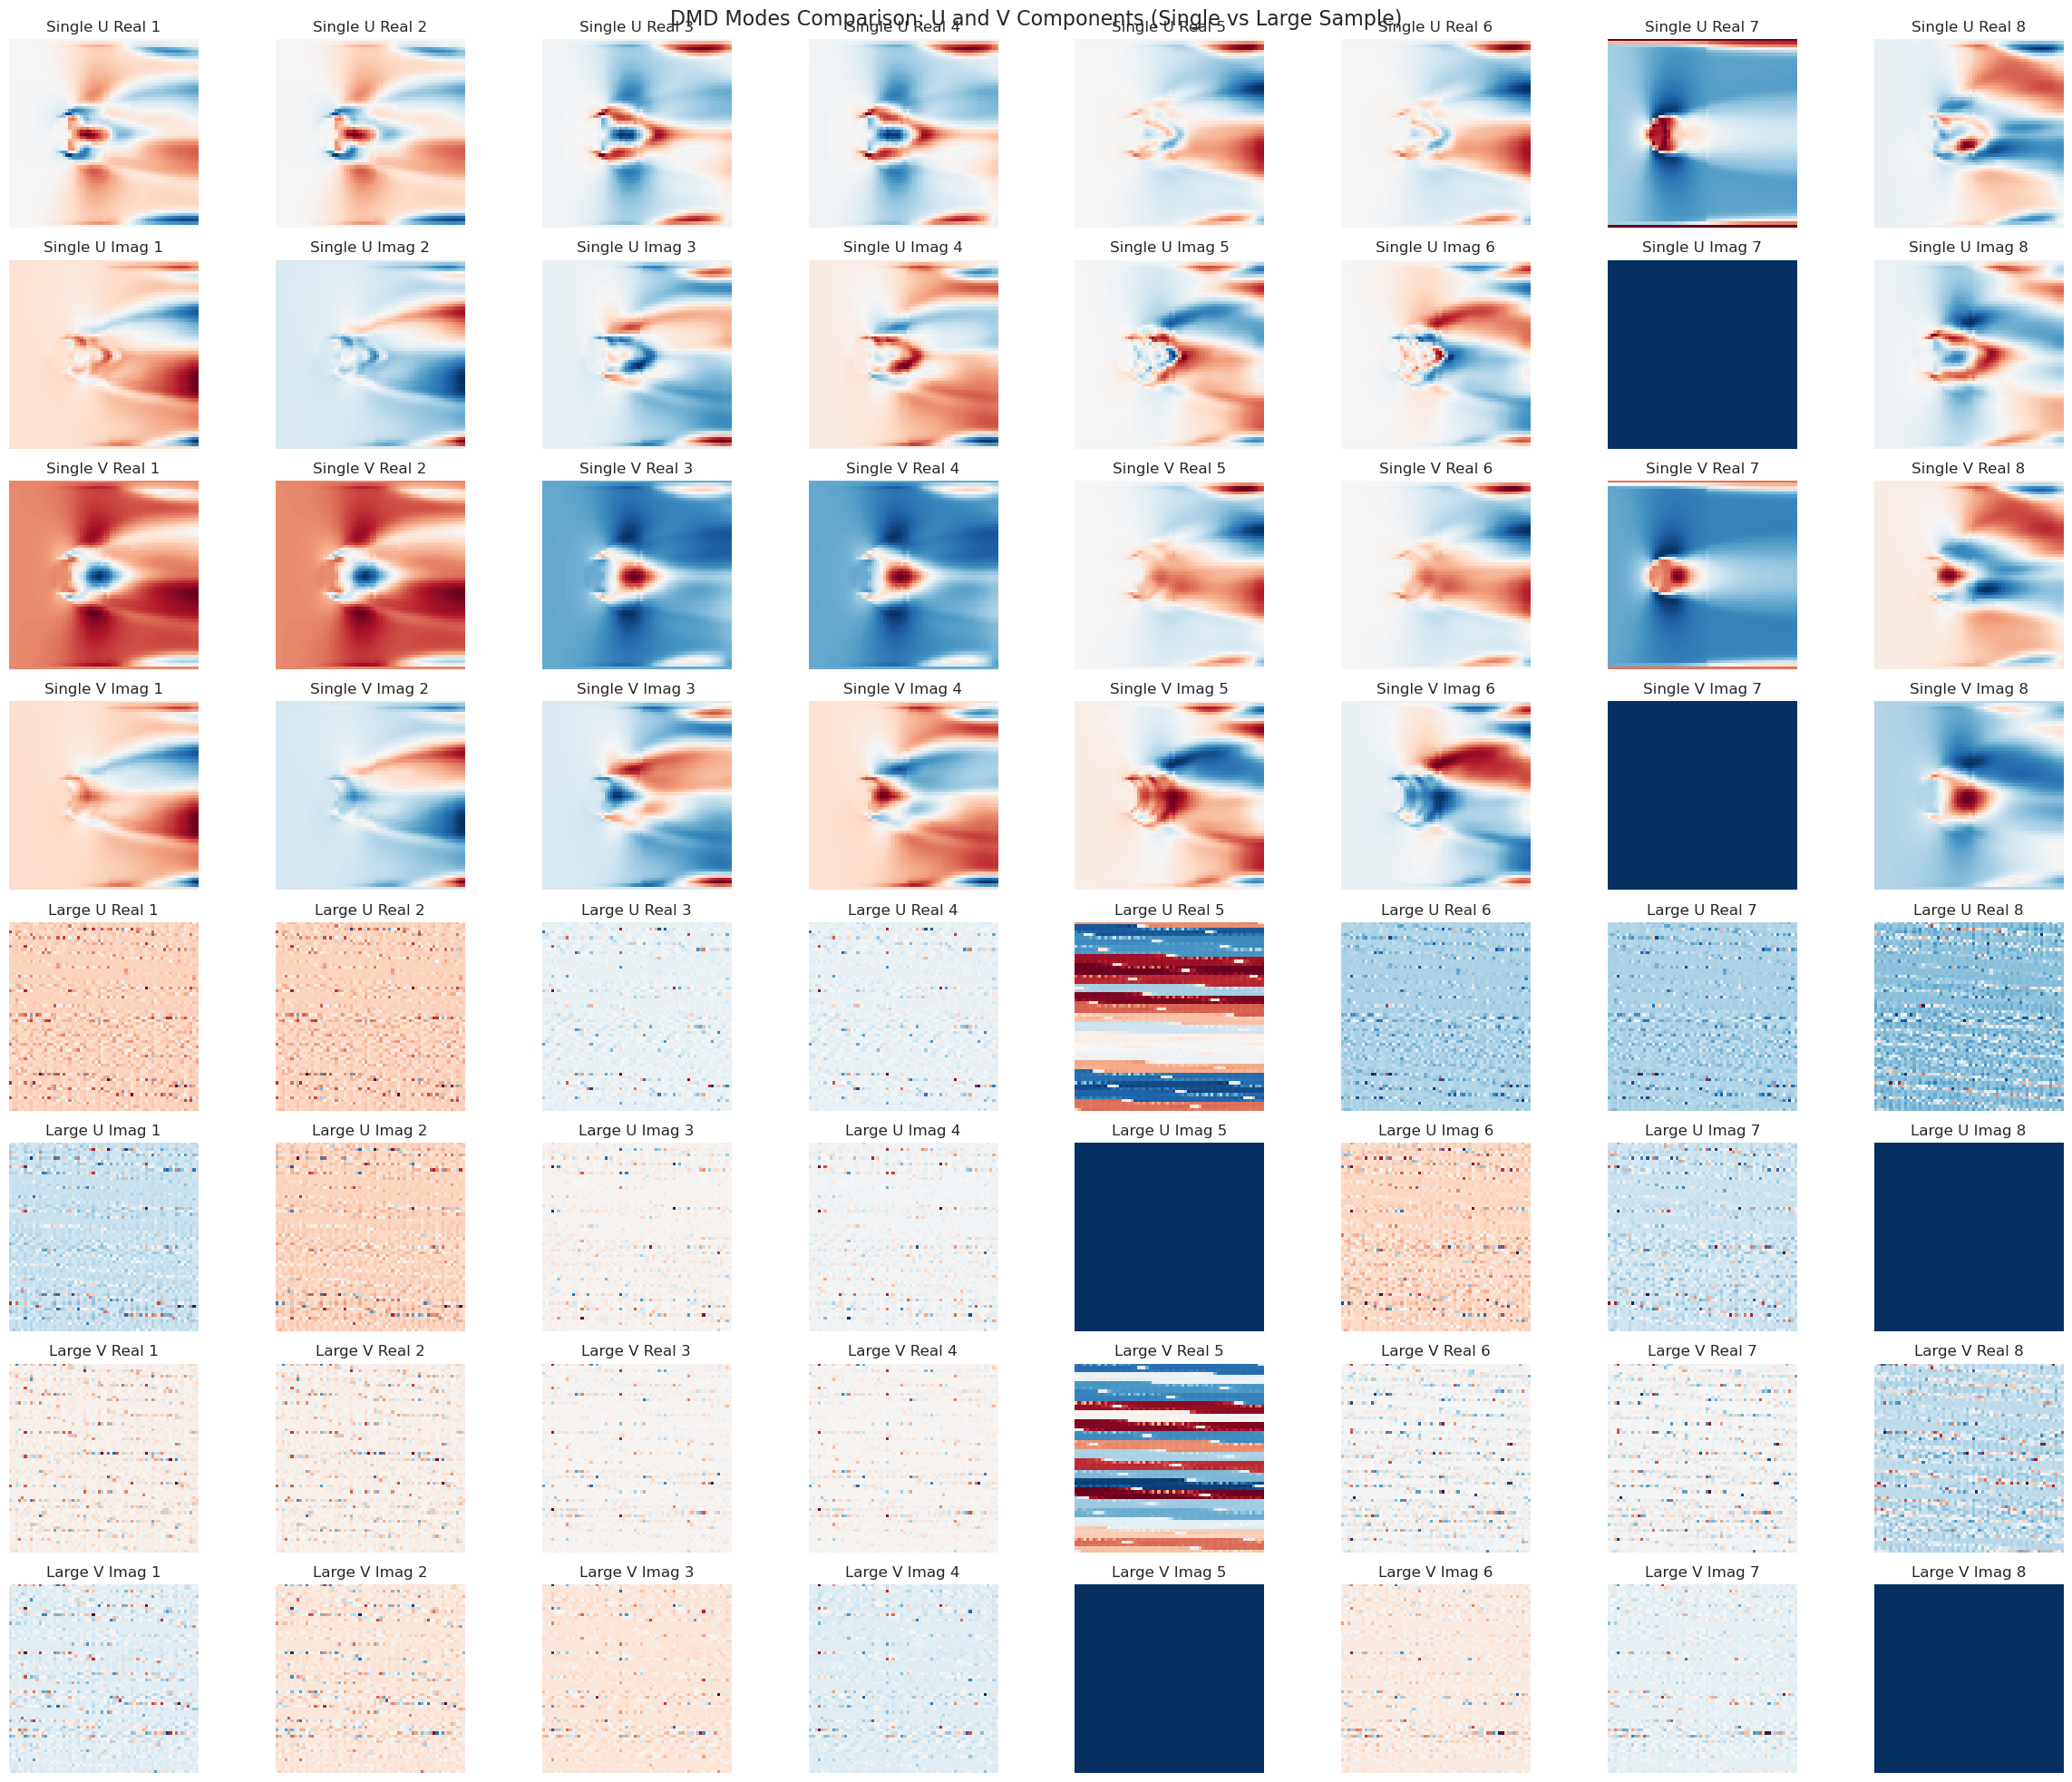

In [25]:
# Visualize the most important modes for cylinder flow
fig, axes = plt.subplots(8, n_modes_to_analyze, figsize=(24, 20))

for i in range(min(n_modes_to_analyze, modes.shape[1])):
    # Single sample mode
    single_idx = single_top_indices[i]
    single_mode = modes[:, single_idx]
    
    # Reshape to [channels, height, width]
    single_mode_reshaped = single_mode.reshape(channels, height, width)
    single_u_real = np.real(single_mode_reshaped[0])
    single_u_imag = np.imag(single_mode_reshaped[0])
    single_v_real = np.real(single_mode_reshaped[1])
    single_v_imag = np.imag(single_mode_reshaped[1])
    
    # Plot single sample modes
    axes[0, i].imshow(single_u_real, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[0, i].set_title(f'Single U Real {i+1}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(single_u_imag, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[1, i].set_title(f'Single U Imag {i+1}')
    axes[1, i].axis('off')
    
    axes[2, i].imshow(single_v_real, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[2, i].set_title(f'Single V Real {i+1}')
    axes[2, i].axis('off')
    
    axes[3, i].imshow(single_v_imag, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[3, i].set_title(f'Single V Imag {i+1}')
    axes[3, i].axis('off')

for i in range(min(n_modes_to_analyze, large_modes.shape[1])):
    # Large sample mode
    large_idx = large_top_indices[i]
    large_mode = large_modes[:, large_idx]
    
    # Reshape to [channels, height, width]
    large_mode_reshaped = large_mode.reshape(channels, height, width)
    large_u_real = np.real(large_mode_reshaped[0])
    large_u_imag = np.imag(large_mode_reshaped[0])
    large_v_real = np.real(large_mode_reshaped[1])
    large_v_imag = np.imag(large_mode_reshaped[1])
    
    # Plot large sample modes
    axes[4, i].imshow(large_u_real, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[4, i].set_title(f'Large U Real {i+1}')
    axes[4, i].axis('off')
    
    axes[5, i].imshow(large_u_imag, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[5, i].set_title(f'Large U Imag {i+1}')
    axes[5, i].axis('off')
    
    axes[6, i].imshow(large_v_real, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[6, i].set_title(f'Large V Real {i+1}')
    axes[6, i].axis('off')
    
    axes[7, i].imshow(large_v_imag, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[7, i].set_title(f'Large V Imag {i+1}')
    axes[7, i].axis('off')

plt.suptitle('DMD Modes Comparison: U and V Components (Single vs Large Sample)', fontsize=16)
plt.tight_layout()
plt.show()

In [26]:
# Analyze mode characteristics specific to cylinder flow
print("\nAnalyzing cylinder flow-specific mode characteristics...")

# Function to analyze wake patterns
def analyze_wake_patterns(mode_u, mode_v, mode_name=""):
    """Analyze wake patterns in cylinder flow modes"""
    # Compute velocity magnitude and vorticity
    velocity_mag = np.sqrt(mode_u**2 + mode_v**2)
    vorticity = compute_vorticity(mode_u, mode_v)
    
    # Analyze wake characteristics
    wake_strength = np.std(vorticity)
    max_velocity = np.max(velocity_mag)
    
    # Find approximate wake region (downstream from cylinder)
    wake_region = velocity_mag[:, height//2:]  # Right half of domain
    wake_activity = np.mean(wake_region)
    
    print(f"{mode_name}:")
    print(f"  Wake strength (vorticity std): {wake_strength:.4f}")
    print(f"  Maximum velocity magnitude: {max_velocity:.4f}")
    print(f"  Wake activity: {wake_activity:.4f}")
    
    return wake_strength, max_velocity, wake_activity

# Analyze top 3 modes for both single and large sample DMD
print("Single Sample DMD - Top 3 Modes:")
for i in range(min(3, len(single_top_indices))):
    idx = single_top_indices[i]
    mode = modes[:, idx].reshape(channels, height, width)
    u_component = np.real(mode[0])
    v_component = np.real(mode[1])
    analyze_wake_patterns(u_component, v_component, f"Mode {i+1}")

print("\nLarge Sample DMD - Top 3 Modes:")
for i in range(min(3, len(large_top_indices))):
    idx = large_top_indices[i]
    mode = large_modes[:, idx].reshape(channels, height, width)
    u_component = np.real(mode[0])
    v_component = np.real(mode[1])
    analyze_wake_patterns(u_component, v_component, f"Mode {i+1}")


Analyzing cylinder flow-specific mode characteristics...
Single Sample DMD - Top 3 Modes:
Mode 1:
  Wake strength (vorticity std): 0.0041
  Maximum velocity magnitude: 0.0694
  Wake activity: 0.0126
Mode 2:
  Wake strength (vorticity std): 0.0041
  Maximum velocity magnitude: 0.0694
  Wake activity: 0.0126
Mode 3:
  Wake strength (vorticity std): 0.0035
  Maximum velocity magnitude: 0.0657
  Wake activity: 0.0103

Large Sample DMD - Top 3 Modes:
Mode 1:
  Wake strength (vorticity std): 0.0112
  Maximum velocity magnitude: 0.1344
  Wake activity: 0.0087
Mode 2:
  Wake strength (vorticity std): 0.0112
  Maximum velocity magnitude: 0.1344
  Wake activity: 0.0087
Mode 3:
  Wake strength (vorticity std): 0.0104
  Maximum velocity magnitude: 0.1480
  Wake activity: 0.0072


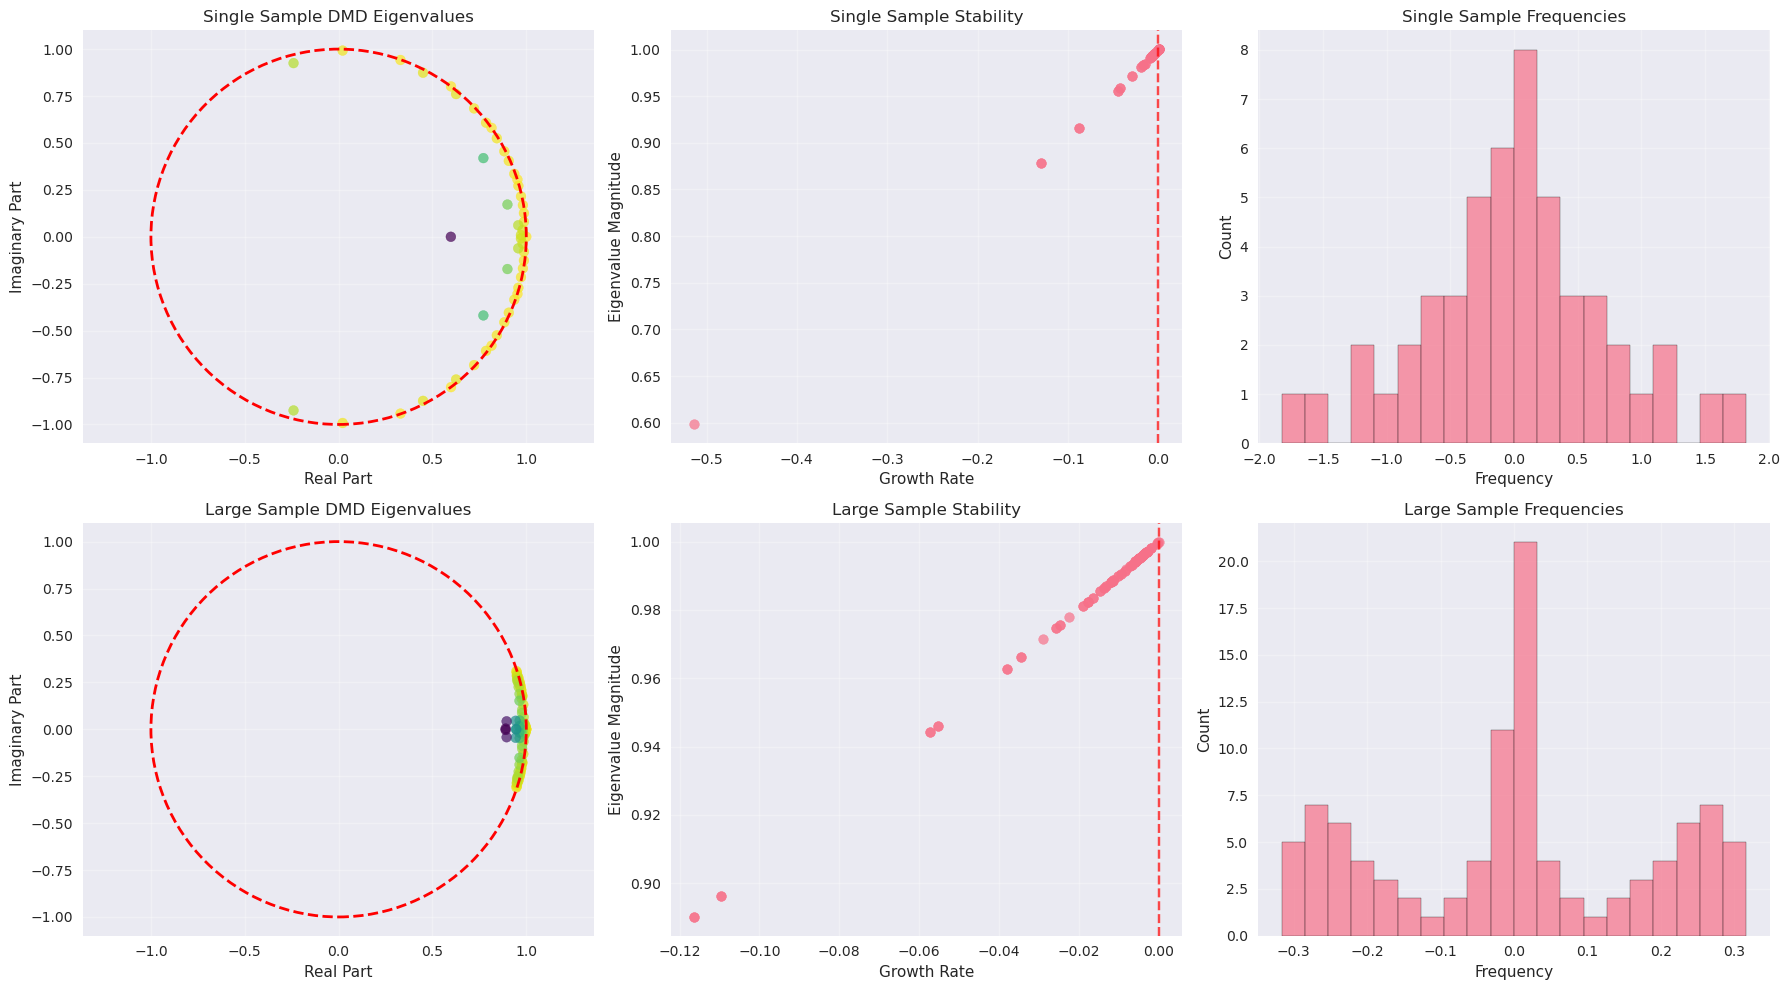

In [27]:
# Compare eigenvalues between single sample and large sample DMD
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Single sample eigenvalues
axes[0, 0].scatter(eigenvalues.real, eigenvalues.imag, c=np.abs(eigenvalues), 
                   cmap='viridis', s=50, alpha=0.7)
axes[0, 0].add_patch(plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2))
axes[0, 0].set_xlabel('Real Part')
axes[0, 0].set_ylabel('Imaginary Part')
axes[0, 0].set_title('Single Sample DMD Eigenvalues')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axis('equal')

axes[0, 1].scatter(growth_rates, np.abs(eigenvalues), alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_xlabel('Growth Rate')
axes[0, 1].set_ylabel('Eigenvalue Magnitude')
axes[0, 1].set_title('Single Sample Stability')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(frequencies, bins=20, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Frequency')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Single Sample Frequencies')
axes[0, 2].grid(True, alpha=0.3)

# Large sample eigenvalues
axes[1, 0].scatter(large_eigenvalues.real, large_eigenvalues.imag, c=np.abs(large_eigenvalues), 
                   cmap='viridis', s=50, alpha=0.7)
axes[1, 0].add_patch(plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2))
axes[1, 0].set_xlabel('Real Part')
axes[1, 0].set_ylabel('Imaginary Part')
axes[1, 0].set_title('Large Sample DMD Eigenvalues')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axis('equal')

axes[1, 1].scatter(large_growth_rates, np.abs(large_eigenvalues), alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[1, 1].set_xlabel('Growth Rate')
axes[1, 1].set_ylabel('Eigenvalue Magnitude')
axes[1, 1].set_title('Large Sample Stability')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].hist(large_frequencies, bins=20, alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Frequency')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Large Sample Frequencies')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Flow Physics Analysis

In [28]:
# %%
print("="*60)
print("PART 4: FLOW PHYSICS ANALYSIS")
print("="*60)

# Analyze flow characteristics
def analyze_flow_statistics(gt_data, pred_data, title="Flow Analysis"):
    """
    Analyze flow statistics including drag, lift, and wake characteristics
    """
    print(f"\n{title}:")
    
    # Reshape data
    gt_reshaped = gt_data.reshape(channels, height, width, -1)  # [channels, height, width, time]
    pred_reshaped = pred_data.reshape(channels, height, width, -1)
    
    # Time-averaged flow fields
    gt_u_mean = np.mean(gt_reshaped[0], axis=2)  # [height, width]
    gt_v_mean = np.mean(gt_reshaped[1], axis=2)
    pred_u_mean = np.mean(pred_reshaped[0], axis=2)
    pred_v_mean = np.mean(pred_reshaped[1], axis=2)
    
    # Flow statistics
    gt_velocity_mag = np.sqrt(gt_u_mean**2 + gt_v_mean**2)
    pred_velocity_mag = np.sqrt(pred_u_mean**2 + pred_v_mean**2)
    
    # Wake analysis (approximate)
    wake_region_y = slice(height//4, 3*height//4)  # Central region
    wake_region_x = slice(width//2, width)         # Downstream region
    
    gt_wake_deficit = np.mean(1.0 - gt_velocity_mag[wake_region_y, wake_region_x])
    pred_wake_deficit = np.mean(1.0 - pred_velocity_mag[wake_region_y, wake_region_x])
    
    print(f"  Ground Truth - Wake deficit: {gt_wake_deficit:.4f}")
    print(f"  Prediction - Wake deficit: {pred_wake_deficit:.4f}")
    print(f"  Wake deficit error: {abs(gt_wake_deficit - pred_wake_deficit):.4f}")
    
    # Vorticity analysis
    gt_vorticity = compute_vorticity(gt_u_mean, gt_v_mean)
    pred_vorticity = compute_vorticity(pred_u_mean, pred_v_mean)
    
    gt_vort_strength = np.std(gt_vorticity)
    pred_vort_strength = np.std(pred_vorticity)
    
    print(f"  Ground Truth - Vorticity strength: {gt_vort_strength:.4f}")
    print(f"  Prediction - Vorticity strength: {pred_vort_strength:.4f}")
    print(f"  Vorticity strength error: {abs(gt_vort_strength - pred_vort_strength):.4f}")
    
    return {
        'gt_u_mean': gt_u_mean, 'gt_v_mean': gt_v_mean,
        'pred_u_mean': pred_u_mean, 'pred_v_mean': pred_v_mean,
        'gt_vorticity': gt_vorticity, 'pred_vorticity': pred_vorticity,
        'wake_deficit_error': abs(gt_wake_deficit - pred_wake_deficit),
        'vorticity_error': abs(gt_vort_strength - pred_vort_strength)
    }

# Analyze single sample
single_analysis = analyze_flow_statistics(gt_denormalized, pred_denormalized, 
                                         "Single Sample DMD Flow Analysis")

# Analyze large sample
large_analysis = analyze_flow_statistics(val_gt_denormalized, large_pred_denormalized,
                                        "Large Sample DMD Flow Analysis")

PART 4: FLOW PHYSICS ANALYSIS

Single Sample DMD Flow Analysis:
  Ground Truth - Wake deficit: -2.3324
  Prediction - Wake deficit: -2.5101
  Wake deficit error: 0.1777
  Ground Truth - Vorticity strength: 0.3321
  Prediction - Vorticity strength: 0.0202
  Vorticity strength error: 0.3120

Large Sample DMD Flow Analysis:
  Ground Truth - Wake deficit: -12.2705
  Prediction - Wake deficit: -2.6118
  Wake deficit error: 9.6587
  Ground Truth - Vorticity strength: 1.0481
  Prediction - Vorticity strength: 0.1501
  Vorticity strength error: 0.8979


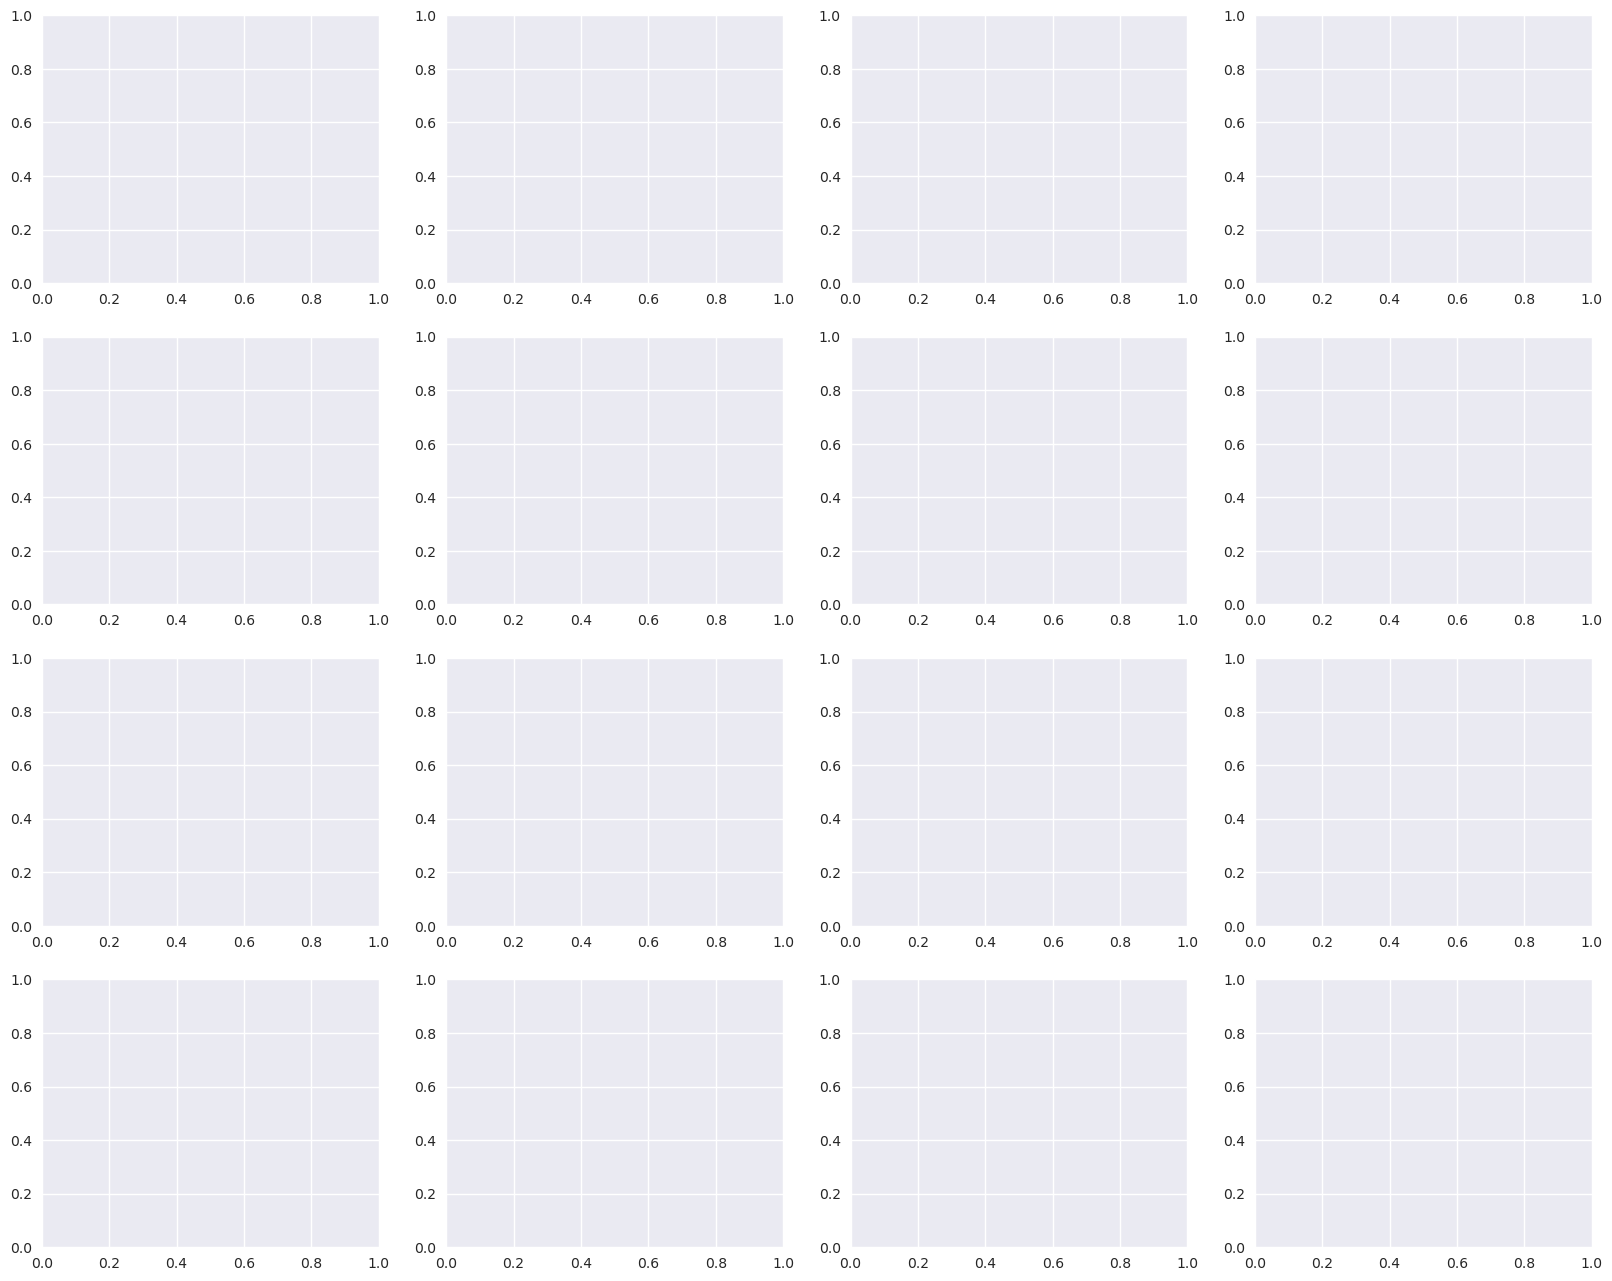

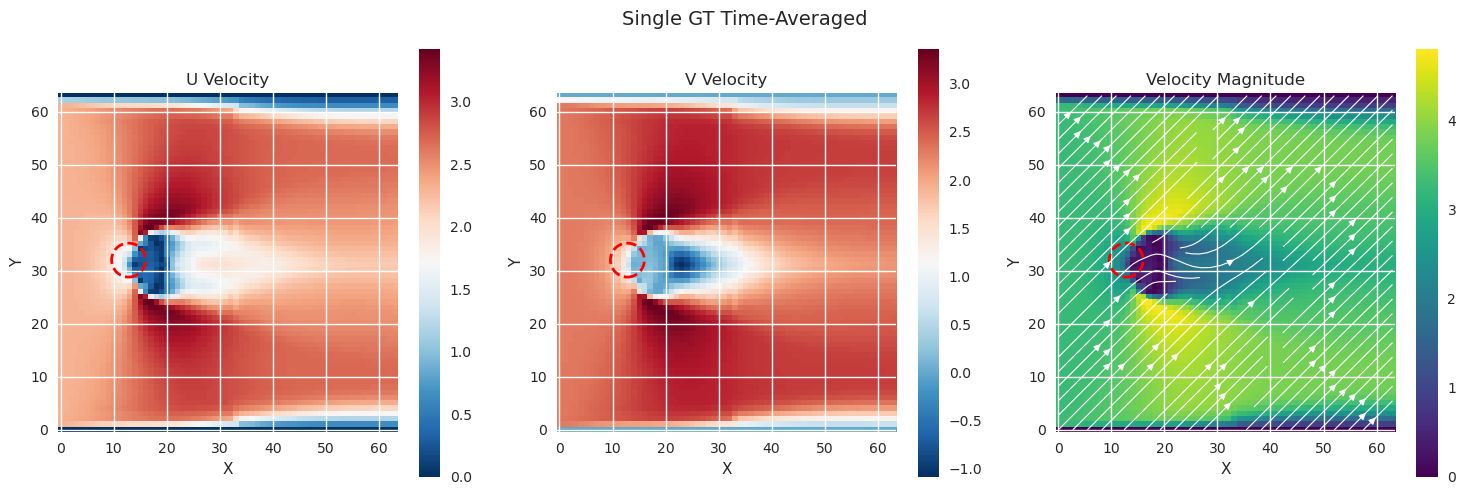

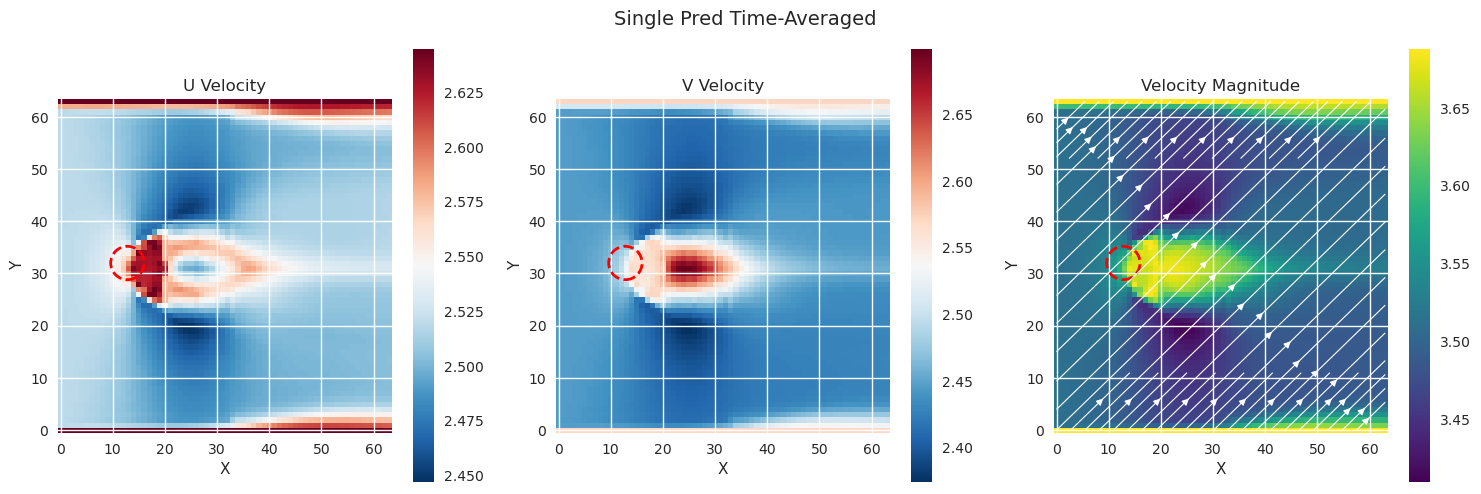

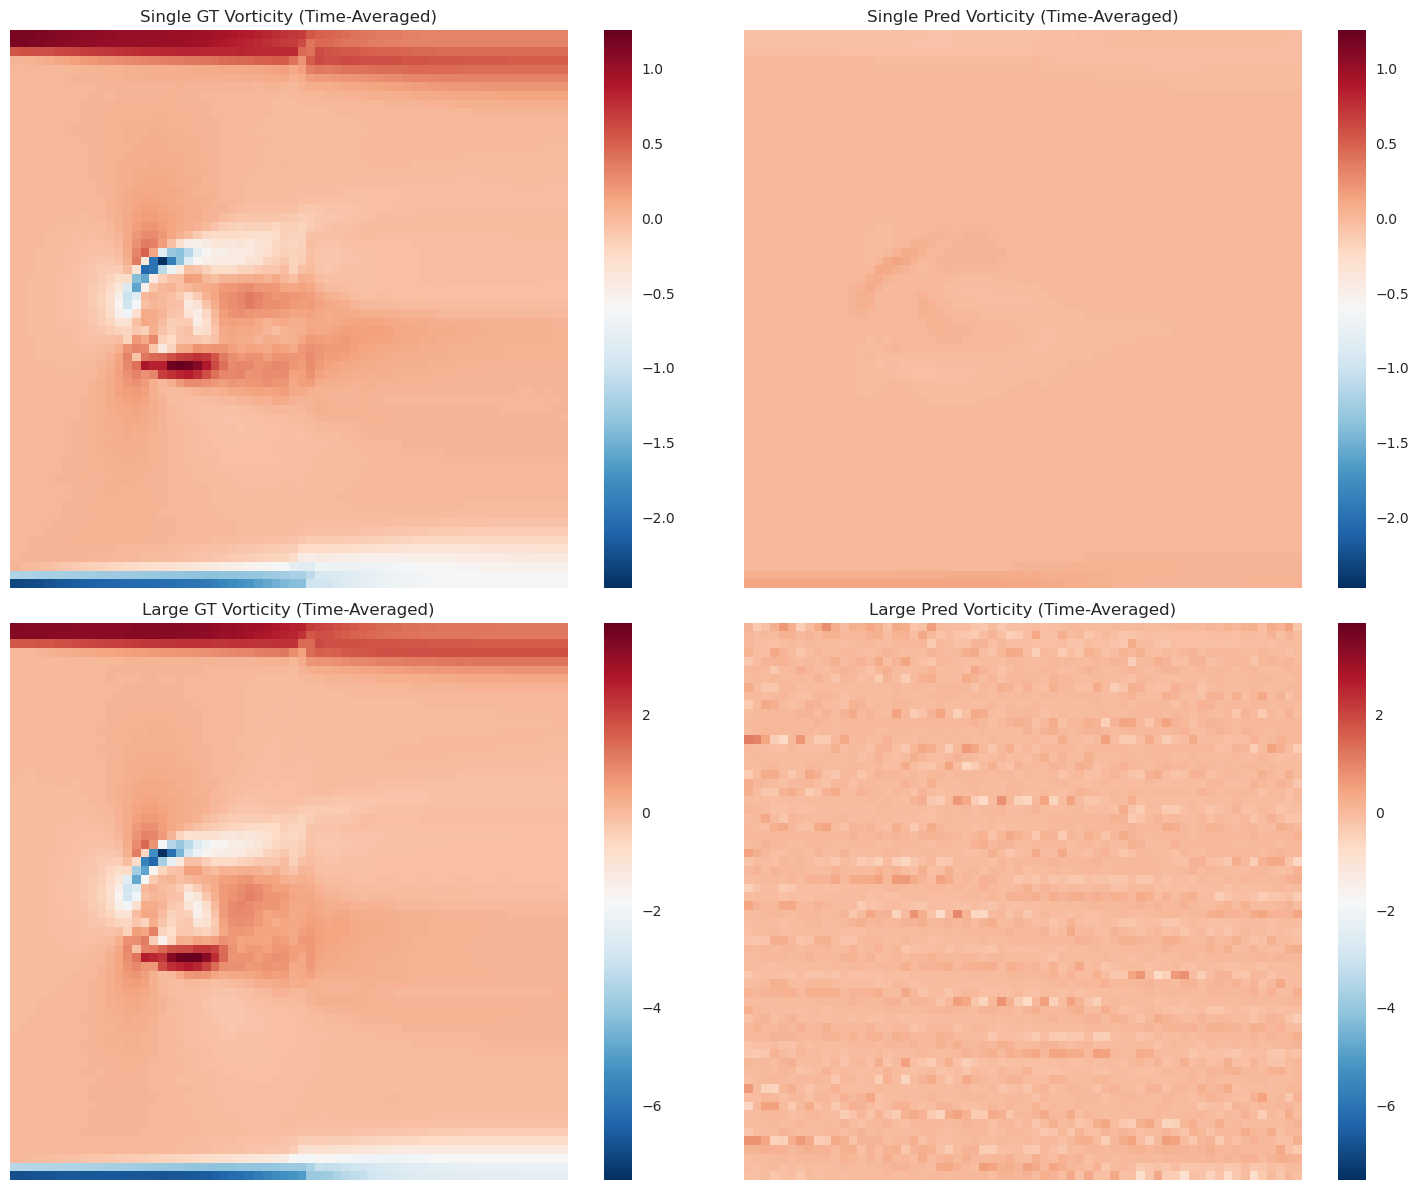

In [29]:
# Visualize time-averaged flow fields
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

# Single sample analysis
single_gt_vort = single_analysis['gt_vorticity']
single_pred_vort = single_analysis['pred_vorticity']
single_gt_u = single_analysis['gt_u_mean']
single_gt_v = single_analysis['gt_v_mean']
single_pred_u = single_analysis['pred_u_mean']
single_pred_v = single_analysis['pred_v_mean']

# Plot single sample results
visualize_cylinder_flow(single_gt_u, single_gt_v, "Single GT Time-Averaged", 
                       figsize=(15, 5), show_streamlines=True)
plt.show()

visualize_cylinder_flow(single_pred_u, single_pred_v, "Single Pred Time-Averaged", 
                       figsize=(15, 5), show_streamlines=True)
plt.show()

# Vorticity comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

vort_vmin = min(single_gt_vort.min(), single_pred_vort.min())
vort_vmax = max(single_gt_vort.max(), single_pred_vort.max())

im1 = axes[0, 0].imshow(single_gt_vort, cmap='RdBu_r', vmin=vort_vmin, vmax=vort_vmax,
                        aspect='equal', origin='lower')
axes[0, 0].set_title('Single GT Vorticity (Time-Averaged)')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(single_pred_vort, cmap='RdBu_r', vmin=vort_vmin, vmax=vort_vmax,
                        aspect='equal', origin='lower')
axes[0, 1].set_title('Single Pred Vorticity (Time-Averaged)')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1])

# Large sample vorticity
large_gt_vort = large_analysis['gt_vorticity']
large_pred_vort = large_analysis['pred_vorticity']

large_vort_vmin = min(large_gt_vort.min(), large_pred_vort.min())
large_vort_vmax = max(large_gt_vort.max(), large_pred_vort.max())

im3 = axes[1, 0].imshow(large_gt_vort, cmap='RdBu_r', vmin=large_vort_vmin, vmax=large_vort_vmax,
                        aspect='equal', origin='lower')
axes[1, 0].set_title('Large GT Vorticity (Time-Averaged)')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(large_pred_vort, cmap='RdBu_r', vmin=large_vort_vmin, vmax=large_vort_vmax,
                        aspect='equal', origin='lower')
axes[1, 1].set_title('Large Pred Vorticity (Time-Averaged)')
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

In [30]:
# Performance comparison and error analysis
print("="*60)
print("PART 5: PERFORMANCE COMPARISON")
print("="*60)

# Compare prediction errors
print("Prediction Error Comparison (Normalized Data):")
print(f"Single Sample DMD:")
for key, value in errors.items():
    print(f"  {key}: {value:.6f}")

print(f"Large Sample DMD:")
for key, value in large_errors.items():
    print(f"  {key}: {value:.6f}")

print("\nPrediction Error Comparison (Denormalized Data):")
print(f"Single Sample DMD:")
print(f"  MSE: {mse_denorm:.6f}")
print(f"  RMSE: {rmse_denorm:.6f}")
print(f"  MAE: {mae_denorm:.6f}")

print(f"Large Sample DMD:")
print(f"  MSE: {large_mse_denorm:.6f}")
print(f"  RMSE: {large_rmse_denorm:.6f}")
print(f"  MAE: {large_mae_denorm:.6f}")

print("\nFlow Physics Error Comparison:")
print(f"Single Sample DMD:")
print(f"  Wake deficit error: {single_analysis['wake_deficit_error']:.6f}")
print(f"  Vorticity strength error: {single_analysis['vorticity_error']:.6f}")

print(f"Large Sample DMD:")
print(f"  Wake deficit error: {large_analysis['wake_deficit_error']:.6f}")
print(f"  Vorticity strength error: {large_analysis['vorticity_error']:.6f}")

PART 5: PERFORMANCE COMPARISON
Prediction Error Comparison (Normalized Data):
Single Sample DMD:
  mse: 0.267944
  rmse: 0.517633
  mae: 0.328394
  relative_error: 1.051165
Large Sample DMD:
  mse: 17.245656
  rmse: 4.152789
  mae: 3.955854
  relative_error: 1.002076

Prediction Error Comparison (Denormalized Data):
Single Sample DMD:
  MSE: 0.796950
  RMSE: 0.892721
  MAE: 0.565894
Large Sample DMD:
  MSE: 51.164310
  RMSE: 7.152923
  MAE: 6.813654

Flow Physics Error Comparison:
Single Sample DMD:
  Wake deficit error: 0.177730
  Vorticity strength error: 0.311955
Large Sample DMD:
  Wake deficit error: 9.658725
  Vorticity strength error: 0.897942


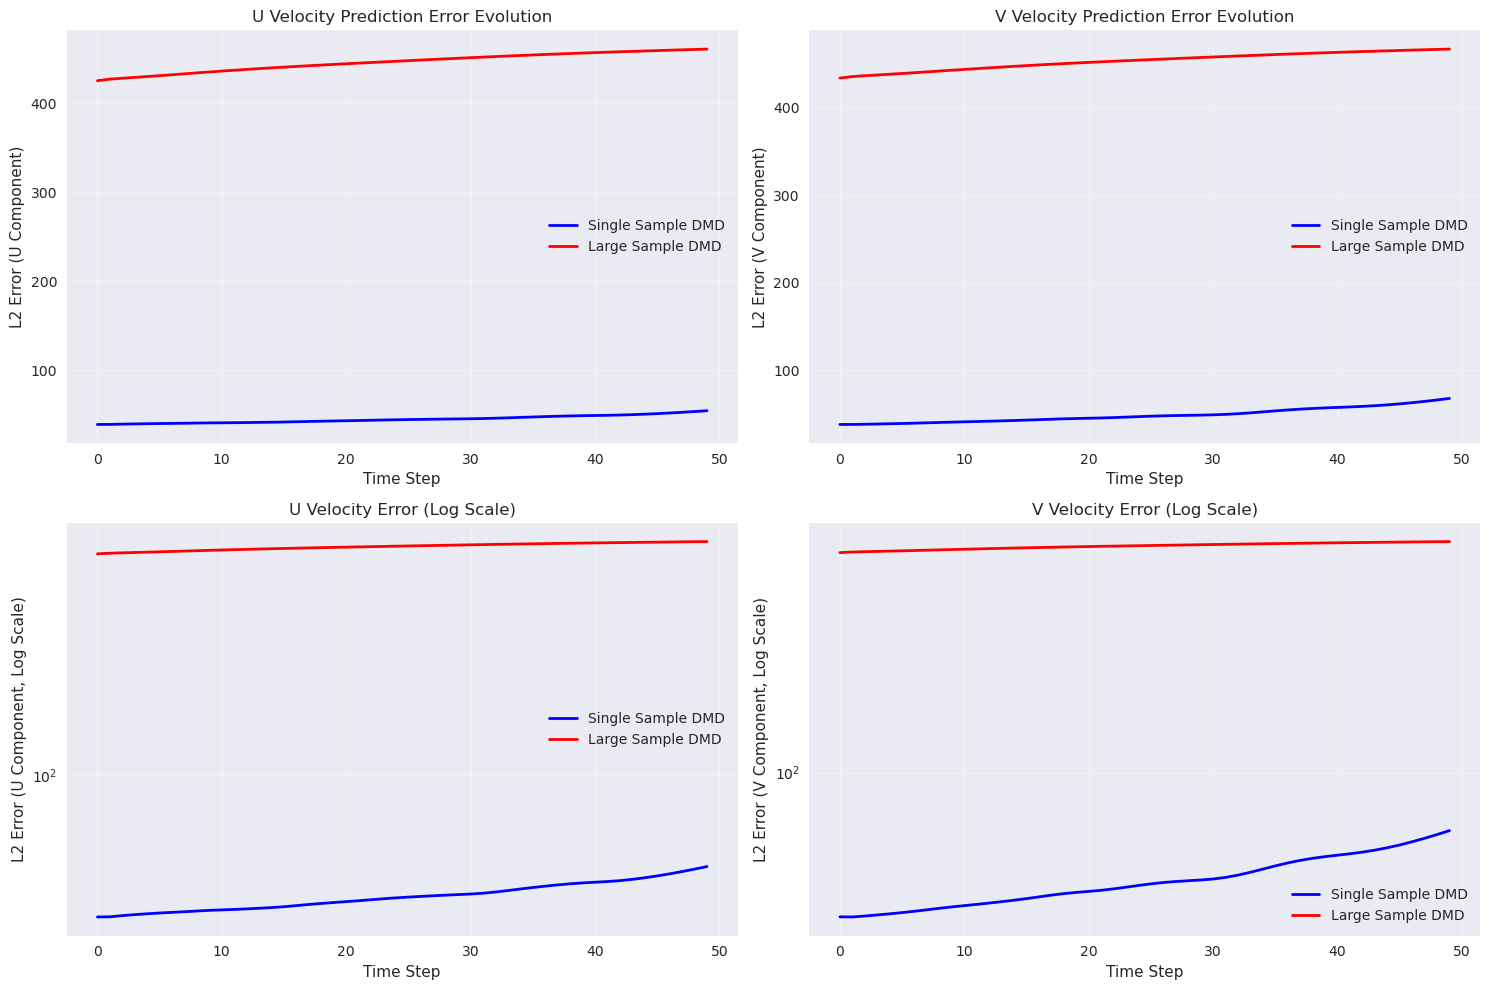

In [31]:
# Error evolution over time for both velocity components
error_steps = min(gt_steps, val_gt_steps, 50)

# Compute separate errors for u and v components
single_error_u_time = []
single_error_v_time = []
large_error_u_time = []
large_error_v_time = []

for t in range(error_steps):
    # Single sample errors
    gt_data_t = gt_denormalized[:, t].reshape(channels, height, width)
    pred_data_t = pred_denormalized[:, t].reshape(channels, height, width)
    
    single_u_err = np.linalg.norm(gt_data_t[0] - pred_data_t[0])
    single_v_err = np.linalg.norm(gt_data_t[1] - pred_data_t[1])
    single_error_u_time.append(single_u_err)
    single_error_v_time.append(single_v_err)
    
    # Large sample errors
    val_gt_data_t = val_gt_denormalized[:, t].reshape(val_channels, height, width)
    large_pred_data_t = large_pred_denormalized[:, t].reshape(val_channels, height, width)
    
    large_u_err = np.linalg.norm(val_gt_data_t[0] - large_pred_data_t[0])
    large_v_err = np.linalg.norm(val_gt_data_t[1] - large_pred_data_t[1])
    large_error_u_time.append(large_u_err)
    large_error_v_time.append(large_v_err)

# Plot error evolution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

time_axis = np.arange(error_steps)

# U component errors
axes[0, 0].plot(time_axis, single_error_u_time, 'b-', label='Single Sample DMD', linewidth=2)
axes[0, 0].plot(time_axis, large_error_u_time, 'r-', label='Large Sample DMD', linewidth=2)
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('L2 Error (U Component)')
axes[0, 0].set_title('U Velocity Prediction Error Evolution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# V component errors
axes[0, 1].plot(time_axis, single_error_v_time, 'b-', label='Single Sample DMD', linewidth=2)
axes[0, 1].plot(time_axis, large_error_v_time, 'r-', label='Large Sample DMD', linewidth=2)
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('L2 Error (V Component)')
axes[0, 1].set_title('V Velocity Prediction Error Evolution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Log scale plots
axes[1, 0].semilogy(time_axis, single_error_u_time, 'b-', label='Single Sample DMD', linewidth=2)
axes[1, 0].semilogy(time_axis, large_error_u_time, 'r-', label='Large Sample DMD', linewidth=2)
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('L2 Error (U Component, Log Scale)')
axes[1, 0].set_title('U Velocity Error (Log Scale)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].semilogy(time_axis, single_error_v_time, 'b-', label='Single Sample DMD', linewidth=2)
axes[1, 1].semilogy(time_axis, large_error_v_time, 'r-', label='Large Sample DMD', linewidth=2)
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('L2 Error (V Component, Log Scale)')
axes[1, 1].set_title('V Velocity Error (Log Scale)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()